### Import Libraries

In [139]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import pandas as pd 
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
import imblearn
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.metrics import roc_auc_score, auc
import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from numpy import arange
from numpy import argmax
from numpy import argmin
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.metrics import balanced_accuracy_score
from imblearn.ensemble import RUSBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import BalancedBaggingClassifier 
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from datetime import datetime
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)
import shap
import itertools
import random
import time

### Define Functions

In [162]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

def calculate_cost(y_true, y_pred, **kwargs):   
    " Find misclassfication costs on the average cost assumption
    "
    
    CM = confusion_matrix(y_true, y_pred)

    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    
    #print('TN = {}, TP = {}, FP = {}, FN = {}'.format(TN, TP, FP, FN))
    costs = FN* mean_stock_value + FP*mean_insurance_costs
    #print('Costs are thus {}'.format(costs))
    return costs 



def make_confusion_matrix(y_test, y_pred):     
    " Plot the confusion matrix of model 
    "
    cf_matrix = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d', annot_kws={'fontsize': 14})
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted label', fontsize = 12)
    ax.set_ylabel('Actual label ', fontsize = 12);
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

def create_model_(optimizer, loss, activation_1, activation_2, batch_size, hidden_layers, 
                  nodes_start, dropout_rate, places_dropout, input_dim): 
    
    " Make autoencoder, based on input hyperparameters defined during hyperparameter optimization"
    
    encoder_inputs = tf.keras.Input(shape = input_dim)
    x = tf.keras.layers.Dense(input_dim, activation=activation_1, input_shape=(input_dim, ))(encoder_inputs) 
    x = tf.keras.layers.Dense(nodes_start, activation=activation_2)(x)  #hidden layer 1
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    if hidden_layers == 1: 
        x = tf.keras.layers.Dense(input_dim, activation=activation_1)(x) #Decoder layer
    
    elif hidden_layers == 3:
        x = tf.keras.layers.Dense(nodes_start/2, activation=activation_2)(x) #Hidden layer 2
        if places_dropout >1:
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
        x = tf.keras.layers.Dense(nodes_start, activation=activation_2)(x) #hidden layer 3
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
        x = tf.keras.layers.Dense(input_dim, activation=activation_1)(x) #Decoder layer 
    
    else: 
        x = tf.keras.layers.Dense(nodes_start/2, activation=activation_2)(x)
        if places_dropout >1:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(nodes_start/4, activation=activation_2)(x)
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
        x = tf.keras.layers.Dense(nodes_start/2, activation=activation_2)(x)
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(nodes_start, activation=activation_2)(x)
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
        x = tf.keras.layers.Dense(input_dim, activation=activation_1)(x)
        
    model = tf.keras.Model(encoder_inputs, x)
    model.compile(optimizer=optimizer, loss = loss)
    model.summary()
    return model 

def create_encoder(optimizer, loss, activation_1, activation_2, batch_size, hidden_layers, 
                  nodes_start, dropout_rate, places_dropout, input_dim, latent_dim): 
    'Create encoder model of variational autoencoder '
    
    encoder_inputs = tf.keras.Input(shape = input_dim)
    x = tf.keras.layers.Dense(input_dim, activation=activation_1, input_shape=(input_dim, ))(encoder_inputs) 
    x = tf.keras.layers.Dense(nodes_start, activation=activation_2)(x)  #hidden layer 1
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    if hidden_layers == 1: 
        z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(encoder_inputs, z, name='encoder')
        
    elif hidden_layers == 3:
        x = tf.keras.layers.Dense(nodes_start/2, activation=activation_2)(x) #Hidden layer 2
        if places_dropout >1:
            x = tf.keras.layers.Dropout(dropout_rate)(x)  
        z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(encoder_inputs, z, name='encoder')
    
    else: 
        x = tf.keras.layers.Dense(nodes_start/2, activation=activation_2)(x)
        if places_dropout >1:
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(nodes_start/4, activation=activation_2)(x)
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
        z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = tf.keras.Model(encoder_inputs, z, name='encoder')
    
    print(encoder.summary())
    return encoder, z_mean, z_log_var


def create_decoder(optimizer, loss, activation_1, activation_2, batch_size, hidden_layers, 
                  nodes_start, dropout_rate, places_dropout, input_dim, latent_dim): 
    'Create decoder model of variational autoencoder '
    latent_inputs = tf.keras.Input(shape = (latent_dim, ))
    
    
    if hidden_layers == 1:
        decoder_output = tf.keras.layers.Dense(input_dim, activation=activation_1)(latent_inputs)
        decoder = tf.keras.Model(latent_inputs, decoder_output , name = 'decoder')
    
    if hidden_layers == 3: 
        x = tf.keras.layers.Dense(nodes_start, activation=activation_2)(latent_inputs) #hidden layer 3
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
        decoder_output = tf.keras.layers.Dense(input_dim, activation=activation_1)(x)
        decoder = tf.keras.Model(latent_inputs, decoder_output , name = 'decoder')
    
    if hidden_layers == 5:
        x = tf.keras.layers.Dense(nodes_start/2, activation=activation_2)(latent_inputs)
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(nodes_start, activation=activation_2)(x)
        if places_dropout >2: 
            x = tf.keras.layers.Dropout(dropout_rate)(x) 
        decoder_output = tf.keras.layers.Dense(input_dim, activation=activation_1)(latent_inputs)
        decoder = tf.keras.Model(latent_inputs, decoder_output , name = 'decoder')
        
    print(decoder.summary())
    return decoder


def evaluate_classifier_CV(model, X_train, y_train, X_test, y_test, SVM=False):
    'evaluate a classifier model via k-fold cross validation '
    
    skf = StratifiedKFold(n_splits=3)
    recalls = []
    precisions = []
    costs = []
    ROC_AUCs = []
    balanced_accuracy = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)
        recalls.append(recall_score(y_test_fold, y_pred_fold, average="binary", pos_label=1))
        precisions.append(precision_score(y_test_fold, y_pred_fold, average="binary", pos_label=1))
        costs.append(calculate_cost(y_test_fold, y_pred_fold))
        balanced_accuracy.append(balanced_accuracy_score(y_test_fold, y_pred_fold))
        if SVM == True:
            ROC_AUCs.append(0)
        if SVM == False:
            y_pred_proba = model.predict_proba(X_test_fold)
            ROC_AUCs.append(roc_auc_score(y_test_fold, y_pred_proba[:, 1])) 
        plot_confusion_matrix(model, X_test_fold, y_test_fold)
        plt.show()
    
    recall, std_recall = np.mean(recalls), np.std(recalls)
    precision, std_precision = np.mean(precisions), np.std(recalls)
    cost, std_cost = np.mean(costs), np.std(costs)
    ROC_AUC, std_ROC_AUC = np.mean(ROC_AUCs), np.std(ROC_AUCs) 
    ba, std_ba = np.mean(balanced_accuracy), np.std(balanced_accuracy)
    print('CV RESULTS mean: Recall = {}, Precision = {}, ROC_AUC = {}, Costs are {}, Balanced Accuracy = {}'.format(recall, precision, ROC_AUC, cost, ba))
    print('CV RESULTS std: Recall = {}, Precision = {}, ROC_AUC = {}, Costs are {}, Balanced Accuracy = {}'.format(std_recall, std_precision, std_ROC_AUC, std_cost, std_ba))
    
    return recalls, precisions, costs, ROC_AUCs, balanced_accuracy

def do_hyperparameter_optimization_vae(all_combs): 
    ROC_AUC = []
    Balanced_Accuracy = []
    CM = []
    precision = []
    recall = []
    with open('Hyperparameters_VAE.txt', 'w') as f:
        
        for i in all_combs:
            #X_train_transformed, X_validate_transformed, y_validate, X_test_transformed, y_test = get_data_for_features(i[9])
            X_train_train_transformed, X_train_validate_transformed = train_test_split(X_train_transformed, 
                                                                        train_size = 0.9, random_state=random_state)
            input_dim = X_train_transformed.shape[1]
            encoder, z_mean, z_log_var = create_encoder(i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], input_dim, i[10])
            vae_input = tf.keras.layers.Input(shape=input_dim, name='VAE_input')
            vae_encoder_output = encoder(vae_input)
            decoder = create_decoder(i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], input_dim, i[10])
            vae_decoder_output = decoder(vae_encoder_output)
            vae = tf.keras.models.Model(vae_input, vae_decoder_output, name='VAE')
            print(vae.summary())
            vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_func(z_mean, z_log_var), metrics=["mse", 'AUC'])
            history = vae.fit(
                X_train_train_transformed, X_train_train_transformed,
                shuffle=True,
                epochs=100,
                batch_size=BATCH_SIZE,
                callbacks=cb,
                validation_data=(X_train_validate_transformed, X_train_validate_transformed))

            reconstructions = vae.predict(X_validate_transformed)
            mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
            mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)
            z_scores = mad_score(mse)
            THRESHOLD = 1
            outliers = z_scores > THRESHOLD 
            cm = confusion_matrix(y_validate, outliers)
            CM.append(cm)
            ba = balanced_accuracy_score(y_validate, outliers)
            Balanced_Accuracy.append(ba)
            CR = classification_report(y_validate, outliers)
            error_df = pd.DataFrame({'reconstruction_error': mse,
                                'true_class': y_validate})
            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc = auc(fpr, tpr)
            ROC_AUC.append(auc(fpr, tpr))
            prec = precision_score(y_validate, outliers)
            precision.append(prec)
            rec = recall_score(y_validate,outliers)
            recall.append(rec)
            f.write('Parameters are {}, BA = {}, ROC_AUC = {}, Precision = {}, Recall = {}'.format(i, auc, ba, prec, rec))
            f.write('\n')
        
    ix1 = argmax(ROC_AUC)
    print('Best parameters are= {}, ROC_AUC= {}, BA = {}, precision = {}, recall = {}'.format(all_combs[ix1], ROC_AUC[ix1], 
            Balanced_Accuracy[ix1], precision[ix1], recall[ix1]))    
    
    ix2 = argmax(Balanced_Accuracy)
    print('Best parameters are= {}, ROC_AUC= {}, BA = {}, precision = {}, recall = {}'.format(all_combs[ix2], ROC_AUC[ix2], 
            Balanced_Accuracy[ix2], precision[ix2], recall[ix2]))    
      
    return ROC_AUC, Balanced_Accuracy, CM, precision, recall, ix1, ix2
    
def evaluate_classifier_test(model, X_train, y_train, X_test, y_test, SVM=False):    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ROC_AUC_test = 0
    if SVM == False:
        y_pred_proba = model.predict_proba(X_test)
        ROC_AUC_test = roc_auc_score(y_test, y_pred_proba[:, 1])
    recall_test = recall_score(y_test, y_pred, average="binary", pos_label=1)
    precision_test = precision_score(y_test, y_pred, average='binary', pos_label = 1)
    balanced_accuracy2 = balanced_accuracy_score(y_test, y_pred)
    cost_test = calculate_cost(y_test, y_pred)
    plot_confusion_matrix(model, X_test, y_test)
    plt.show()
    print('Test set results: Recall = {}, Precision = {}, ROC_AUC = {}, balanced accuracy = {},  Costs are {}'.
          format(recall_test, precision_test, ROC_AUC_test, balanced_accuracy2, cost_test))
    return model


def evaluate_classifier_validate(model, X_train, y_train, X_test, y_test, SVM=False):    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ROC_AUC_test = 0
    if SVM == False:
        y_pred_proba = model.predict_proba(X_test)
        ROC_AUC_test = roc_auc_score(y_test, y_pred_proba[:, 1])
    recall_test = recall_score(y_test, y_pred, average="binary", pos_label=1)
    precision_test = precision_score(y_test, y_pred, average='binary', pos_label = 1)
    balanced_accuracy2 = balanced_accuracy_score(y_test, y_pred)
    #cost_test = calculate_cost(y_test, y_pred)
    #plot_confusion_matrix(model, X_test, y_test)
    #plt.show()
    #print('Test set results: Recall = {}, Precision = {}, ROC_AUC = {}, balanced accuracy = {},  Costs are {}'.
    #      format(recall_test, precision_test, ROC_AUC_test, balanced_accuracy2, cost_test))
    return recall_test, precision_test, balanced_accuracy2, ROC_AUC_test
    
    
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 

    
def do_feature_selection(k, X, X_train, X_validate, X_test):
    selector = SelectKBest(score_func=f_classif, k=k)
    fit = selector.fit(X_train, y_train)  #should i do this on train data or all x-data. 
    cols = selector.get_support(indices=True)
    X = X.iloc[:,cols]
    X_train = X_train.iloc[:,cols]
    X_validate = X_validate.iloc[:,cols]
    X_test = X_test.iloc[:,cols]
    return X, X_train, X_validate, X_test


def do_feature_selection_(k, X, X_train, X_test):
    selector = SelectKBest(score_func=f_classif, k=k)
    fit = selector.fit(X_train, y_train)  #should i do this on train data or all x-data. 
    cols = selector.get_support(indices=True)
    X = X.iloc[:,cols]
    X_train = X_train.iloc[:,cols]
    X_test = X_test.iloc[:,cols]
    return X, X_train, X_test


def do_undersampling_(model, sampler, X_train, y_train):
    X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
    evaluation_range = [0.05, 0.1, 0.2, 0.3, 0.5]
    ROC_AUC =[]
    
    for i in evaluation_range:
        if sampler == 'RU':
            undersample = RandomUnderSampler(sampling_strategy = i, random_state=random_state)
        if sampler == 'NM':
            undersample = NearMiss(version=1, n_neighbors=3, sampling_strategy=i)
        X_train_U, y_train_U = undersample.fit_resample(X_train, y_train)
        clf = model.fit(X_train_U, y_train_U)
        y_pred = clf.predict(X_validate)
        y_pred = y_pred.astype(str)
        y_test = y_validate.astype(str)
        y_pred_proba = clf.predict_proba(X_validate)
        ROC_AUC_test = roc_auc_score(y_test, y_pred_proba[:, 1])
        ROC_AUC.append(ROC_AUC_test)
        
    ix = argmax(ROC_AUC)
    print('Optimal sampling strategy = {}, corresponding ROC_AUC are {}'.format(evaluation_range[ix], ROC_AUC[ix]))
    
    sampling_strategy= evaluation_range[ix]
    
    if sampler == 'RU':
        RU = RandomUnderSampler(random_state=random_state, sampling_strategy=sampling_strategy)
        X_train_RU, y_train_RU = RU.fit_resample(X_train, y_train)
    if sampler == 'NM':
        NM = NearMiss(version=1, n_neighbors=3, sampling_strategy=sampling_strategy)
        X_train_RU, y_train_RU = NM.fit_resample(X_train, y_train)
    
    return X_train_RU, y_train_RU
    
def plot_metrics(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.legend(['Training loss', 'validation loss'])
    plt.show()

    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend(['auc', 'val_auc'])
    plt.show()
    
def do_hyperparameter_optimization_ae(all_combs): 
    ROC_AUC = []
    Balanced_Accuracy = []
    CM = []
    precision = []
    recall = []

    with open('Hyperparameters_AE2.txt', 'w') as f:

        for i in all_combs:
            #X_train_transformed, X_validate_transformed, y_validate, X_test_transformed, y_test = get_data_for_features(i[9])
            X_train_train_transformed, X_train_validate_transformed = train_test_split(X_train_transformed, 
                                                                        train_size = 0.9, random_state=random_state)
            input_dim = X_train_train_transformed.shape[1]
            autoencoder = create_model_(i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], input_dim)
            history = autoencoder.fit(
                X_train_train_transformed, X_train_train_transformed,
                shuffle=True,
                epochs=100,
                batch_size=i[4],
                callbacks=cb,
                validation_data=(X_train_validate_transformed, X_train_validate_transformed))

            reconstructions = autoencoder.predict(X_validate_transformed)
            mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
            mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)
            z_scores = mad_score(mse)
            THRESHOLD = 1
            outliers = z_scores > THRESHOLD 
            cm = confusion_matrix(y_validate, outliers)
            CM.append(cm)
            ba = balanced_accuracy_score(y_validate, outliers)
            Balanced_Accuracy.append(ba)
            CR = classification_report(y_validate, outliers)
            error_df = pd.DataFrame({'reconstruction_error': mse,
                                'true_class': y_validate})
            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc = auc(fpr, tpr)
            ROC_AUC.append(auc(fpr, tpr))
            prec = precision_score(y_validate, outliers)
            precision.append(prec)
            rec = recall_score(y_validate,outliers)
            recall.append(rec)
            f.write('Parameters are {}, BA = {}, ROC_AUC = {}, Precision = {}, Recall = {}'.format(i, auc, ba, prec, rec))
            f.write('\n')

        ix1 = argmax(ROC_AUC)
        print('Best parameters are= {}, ROC_AUC= {}, BA = {}, precision = {}, recall = {}'.format(all_combs[ix1], ROC_AUC[ix1], 
                Balanced_Accuracy[ix1], precision[ix1], recall[ix1]))    

        ix2 = argmax(Balanced_Accuracy)
        print('Best parameters are= {}, ROC_AUC= {}, BA = {}, precision = {}, recall = {}'.format(all_combs[ix2], ROC_AUC[ix2], 
                Balanced_Accuracy[ix2], precision[ix2], recall[ix2]))    

        return ROC_AUC, Balanced_Accuracy, CM, precision, recall, ix1, ix2

    
def do_hyperparameter_optimization_dae(all_combs): 
    ROC_AUC = []
    Balanced_Accuracy = []
    CM = []
    precision = []
    recall = []
    
    with open('Hyperparameters_DAE3.txt', 'w') as f:
        for i in all_combs:
            #X_train_transformed, X_validate_transformed, y_validate, X_test_transformed, y_test = get_data_for_features(i[9])
            X_train_train_transformed, X_train_validate_transformed = train_test_split(X_train_transformed, 
                                                                        train_size = 0.9, random_state=random_state)
            X_train_train_transformed_n = gaussian_noise(X_train_train_transformed, 0, i[10])
            X_train_validate_transformed_n = gaussian_noise(X_train_validate_transformed, 0, i[10])
            X_validate_transformed_n = gaussian_noise(X_validate_transformed, 0, i[10])
            X_test_transformed_n = gaussian_noise(X_test_transformed, 0, i[10])

            input_dim = X_train_train_transformed_n.shape[1]
            dae = create_model_(i[0], i[1], i[2], i[3], i[4], i[5], i[6], i[7], i[8], input_dim)
            history = dae.fit(
                X_train_train_transformed_n, X_train_train_transformed_n,
                shuffle=True,
                epochs=125,
                batch_size=i[4],
                callbacks=cb,
                validation_data=(X_train_validate_transformed_n, X_train_validate_transformed_n))

            reconstructions = dae.predict(X_validate_transformed)
            mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
            mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)
            z_scores = mad_score(mse)
            THRESHOLD = 1
            outliers = z_scores > THRESHOLD 
            cm = confusion_matrix(y_validate, outliers)
            CM.append(cm)
            ba = balanced_accuracy_score(y_validate, outliers)
            Balanced_Accuracy.append(ba)
            CR = classification_report(y_validate, outliers)
            error_df = pd.DataFrame({'reconstruction_error': mse,
                                'true_class': y_validate})
            fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
            roc = auc(fpr, tpr)
            ROC_AUC.append(auc(fpr, tpr))
            prec = precision_score(y_validate, outliers)
            precision.append(prec)
            rec = recall_score(y_validate,outliers)
            recall.append(rec)
            f.write('Parameters are {}, BA = {}, ROC_AUC = {}, Precision = {}, Recall = {}'.format(i, auc, ba, prec, rec))
            f.write('\n')
        
    ix1 = argmax(ROC_AUC)
    print('Best parameters are= {}, ROC_AUC= {}, BA = {}, precision = {}, recall = {}'.format(all_combs[ix1], ROC_AUC[ix1], 
            Balanced_Accuracy[ix1], precision[ix1], recall[ix1]))    
    
    ix2 = argmax(Balanced_Accuracy)
    print('Best parameters are= {}, ROC_AUC= {}, BA = {}, precision = {}, recall = {}'.format(all_combs[ix2], ROC_AUC[ix2], 
            Balanced_Accuracy[ix2], precision[ix2], recall[ix2]))    
      
    return ROC_AUC, Balanced_Accuracy, CM, precision, recall, ix1, ix2    
    
def create_model(optimizer='adam', loss='mse', activation_1='relu', activation_2 ='sigmoid'):
        
        autoencoder = tf.keras.models.Sequential([
        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation=activation_1, input_shape=(input_dim, )),   #input layer
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(8, activation=activation_2),
        tf.keras.layers.Dense(4, activation=activation_2),
        tf.keras.layers.Dense(8, activation=activation_2),
        # reconstruction / decode
        tf.keras.layers.Dense(input_dim, activation=activation_1)
    ])
        dot_img_file = '/tmp/AE.png'
        tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=True)
        autoencoder.compile(optimizer=optimizer, 
                    loss=loss,  
                    metrics=["mse", 'AUC', 'accuracy'])  
        
        autoencoder.summary()
        
        return autoencoder
    
    
def create_dae(optimizer='adam', loss='mse', activation_1='relu', activation_2 ='sigmoid'):
    
        autoencoder = tf.keras.models.Sequential([
        # deconstruct / encode
        tf.keras.layers.Dense(input_dim, activation=activation_1, input_shape=(input_dim, )),   #input layer
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(8, activation=activation_2),
        tf.keras.layers.Dense(4, activation=activation_2),
        tf.keras.layers.Dense(2, activation=activation_2),
        tf.keras.layers.Dense(4, activation=activation_2),
        tf.keras.layers.Dense(8, activation=activation_2),
        # reconstruction / decode
        tf.keras.layers.Dense(input_dim, activation=activation_1)
    ])
        dot_img_file = '/tmp/DAE.png'
        tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=True)
        autoencoder.compile(optimizer=optimizer, 
                    loss=loss,  
                    metrics=["mse", 'AUC', 'accuracy'])  
        
        autoencoder.summary()
        
        return autoencoder


def cost_per_threshold(classifier, X, y):
    
    thresholds = np.arange(start=0.0005, stop=1, step=0.025)
    fn, fp = [], []
    roc = []
    balanced_accuracy = []
    
    for threshold in thresholds:

        # custom threshold
        y_prob = np.array(list(map(predict_prob, classifier.predict(X))))
        y_pred = (y_prob[:,1] > threshold).astype(int)
        roc_score = roc_auc_score(y, y_prob[:, 1])
        ba = balanced_accuracy_score(y, y_pred)
        
        # extracting performance indicators
        false_positives = confusion_matrix(y, y_pred)[0,1]
        false_negatives = confusion_matrix(y, y_pred)[1,0]
        
        # add to lists
        fp.append(false_positives)
        fn.append(false_negatives)
        roc.append(roc_score)
        balanced_accuracy.append(ba)

    # convert to numpy arrays
    fp = np.asarray(fp)
    fn = np.asarray(fn)
    mean_stock_value = 340.18
    mean_insurance_costs = 1.68
    costs = fn* mean_stock_value + fp*mean_insurance_costs
    
    return thresholds, fp, fn, costs, balanced_accuracy


def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        reconstruction_loss_factor = 1000
        print(np.shape(y_true))
        print(np.shape(y_predict))
        reconstruction_loss = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_predict), axis=[1])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tf.keras.backend.sum(1.0 + encoder_log_variance - tf.keras.backend.square(encoder_mu) - tf.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

def merge_test_set(X_test, y_test, y_pred):
    X_test = X_test.reset_index()
    y_test = y_test.reset_index()
    y_pred = y_pred.reset_index()
    test_df = pd.concat([X_test, y_test, y_pred], axis=1)
    return pd.DataFrame(test_df)

def calculate_insurance(stock_value):
    if stock_value < 500:
        return 1.73
    if 500 <= stock_value < 1000:
        return 3.46
    if 1000 <= stock_value < 1500:
        return 5.19
    if 1500 <= stock_value < 2000:
        return 6.92
    if 2000 <= stock_value < 2500:
        return 8.65
    if 2500 <= stock_value < 3000:
        return 10.38
    if 3000 <= stock_value < 3500:
        return 12.11
    if 3500 <= stock_value < 4000:
        return 13.84
    if 4000 <= stock_value < 4500:
        return 15.57
    if 4500 <= stock_value < 5000:
        return 17.30
    if stock_value >= 5000: 
        return 19.03
    
def determine_misclass(pred, lost):
    if pred == 1 and lost == 1:
        misclass = 'TP'
    if pred == 1 and lost == 0:
        misclass = 'FP'
    if pred == 0 and lost == 1:
        misclass = 'FN'
    if pred == 0 and lost == 0:
        misclass = 'TN'
    return misclass 

def determine_misclass_cost(classification, stock_value):
    if classification == 'FP':
        return calculate_insurance(stock_value)
    if classification == 'FN':
        return stock_value
    else:
        return 0
    
    
def cost_test_set(X_test, y_test, y_pred):
    y_pred = pd.DataFrame(y_pred)
    #y_pred.set_axis(['Pred'], axis='columns', inplace=False)
    test_df = merge_test_set(X_test['stock_value'], y_test, y_pred)
    test_df['Pred'] = test_df.iloc[:,-1:]
    test_df['stock_value_normal'] = np.exp(test_df["stock_value"]) 
    test_df['classification'] = test_df.apply(lambda x: determine_misclass(x.Pred, x.Is_lost_item), axis=1)
    test_df['misclass_cost'] = test_df.apply(lambda x: determine_misclass_cost(x.classification, x.stock_value_normal), axis=1)
    print('Total misclassification costs are ', np.sum(test_df['misclass_cost']))
    return np.sum(test_df['misclass_cost'])
    
def mad_score(points):
    """https://www.itl.nist.gov/div898/handbook/eda/section3/eda35h.htm """
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

In [117]:
y_pred = pd.DataFrame(y_pred)
y_pred.set_axis(['Pred'], axis='columns', inplace=True)
test_df = merge_test_set(X_test['stock_value'], y_test, y_pred)
test_df.columns

Index(['index', 'stock_value', 'index', 'Is_lost_item', 'index', 'Pred'], dtype='object')

# 0. Define Variables

In [3]:
mean_stock_value = 340.18
mean_insurance_costs = 1.68
random_state = 1
np.random.seed(random_state)
ratio_train = 0.9
ratio_test = 0.1
cost_scorer = make_scorer(calculate_cost, greater_is_better = False)   #Define own scoring function

# 1. Import Data

In [276]:
#import data
X = pd.read_csv('X_modeling2.csv', index_col = 0)
y = pd.read_csv('y_modeling2.csv', index_col = 0)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]

## 1.1 Business Rules evaluation

0.423963133640553
0.003585486573911688
0.5620689332785928
0.5620689332785928


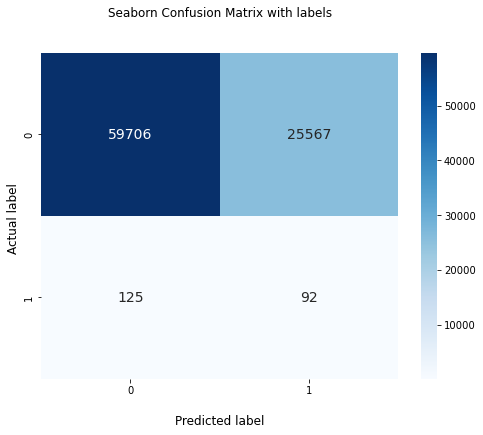

Total misclassification costs are  116008.12999999999


116008.12999999999

In [163]:
#Do stratified train-val-test split 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=ratio_test, random_state=random_state)
y_pred = X_test["parent_securityshipment_Insurance"].astype(int)

print(recall_score(y_test, y_pred, average="binary", pos_label=1))
print(precision_score(y_test, y_pred, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
print(auc(fpr, tpr)) 

make_confusion_matrix(y_test, y_pred)
cost_test_set(X_test, y_test, y_pred)

In [59]:
recall_BR = []
precision_BR = []
BA_BR = []
ROC_AUC_BR = []

for j in range(4):
    #Define train validate and test sets 
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=ratio_test, random_state=j)
    y_pred = X_test["parent_securityshipment_Insurance"].astype(int)
    
    #Define optimal found model  
    recall = recall_score(y_test, y_pred, average="binary", pos_label=1)
    prec = precision_score(y_test, y_pred, average="binary", pos_label=1)
    ba = balanced_accuracy_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    ROC_AUC = auc(fpr, tpr)
    
    recall_BR.append(recall)
    precision_BR.append(prec)
    BA_BR.append(ba)
    ROC_AUC_BR.append(ROC_AUC)

print('Results BR are. Mean recall {}, std recall {}. Mean precision {}, std recall {}. Mean BA = {}, std BA = {}'.format(
np.mean(recall_BR), np.std(recall_BR), np.mean(precision_BR), np.std(precision_BR), np.mean(BA_BR), np.std(BA_BR)))

Results BR are. Mean recall 0.4216589861751152, std recall 0.017995966995176624. Mean precision 0.0035758118257204295, std recall 0.00014955139741037915. Mean BA = 0.5613317036348586, std BA = 0.008891689959357438


## 1.2 Data split

In [277]:
#Drop features related to insure features afterwards, as these are not predictive and only used to compare current performance. 
X = X.drop('parent_securityshipment_Insurance', axis=1)
X = X.drop('parent_securityshipment_None', axis=1)
X = X.drop('parent_securityshipment_Signature', axis=1)

In [278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=ratio_test, random_state=random_state)
print(X_train.shape)

(769408, 226)


# 2. Supervised Machine Learning Results

## 2.1 Decision Trees

### 2.1.1 Find optimal Undersampled datasets

In [283]:
#Find optimal Undersampled Training Data
model = DecisionTreeClassifier(random_state=random_state, class_weight= 'balanced')   
X_train_NM, y_train_NM = do_undersampling_(model, 'NM', X_train, y_train)  
X_train_RU, y_train_RU = do_undersampling_(model, 'RU', X_train, y_train) 

Optimal sampling strategy = 0.1, corresponding ROC_AUC are 0.5588404189882482
Optimal sampling strategy = 0.2, corresponding ROC_AUC are 0.6246681997987042


### 2.1.2 Do hyperparameter optimization for four different models

In [9]:
#Hyperparameter optimization
param_grid = {
    'criterion': ['entropy', 'log_loss', 'gini'],
    'max_depth': [5,10, 15, None],
    'max_features': [5,10, None],
    'min_samples_split': [50, 150, None],
    'class_weight': ['balanced', None]}

param_grid2 = {
    'base_estimator__criterion': ['entropy', 'log_loss','gini'],
    'base_estimator__max_depth': [5, None],
    'base_estimator__max_features': [5, 10, None],
    'base_estimator__min_samples_split': [50, 100, None]}

#Define models
DT = DecisionTreeClassifier(random_state=random_state)
skf = StratifiedKFold(n_splits=5, shuffle = True)

#Model 1 - RU
start_time = time.time()
grid_search = RandomizedSearchCV(estimator = DT, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                         n_iter=20, cv = skf, n_jobs = -1, verbose = -1, return_train_score = True)
grid_search.fit(X_train_RU, y_train_RU)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print("--- %s seconds ---" % (time.time() - start_time))

#Model 2 - NM
start_time = time.time()
grid_search = RandomizedSearchCV(estimator = DT, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                         n_iter=20, cv = skf, n_jobs = -1, verbose = -1, return_train_score = True)
grid_search.fit(X_train_NM, y_train_NM)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print("--- %s seconds ---" % (time.time() - start_time))

#Model 3 - RUSBoost
start_time = time.time()
grid_search = RandomizedSearchCV(RUSBoostClassifier(base_estimator=DT), param_distributions = param_grid2, 
                                     n_iter=20, scoring='balanced_accuracy', cv=skf, n_jobs=-1, verbose=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print(grid_search.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

#Model 4 - UnderBagging
start_time = time.time()
grid_search = RandomizedSearchCV(BalancedBaggingClassifier(base_estimator=DT), param_distributions = param_grid2, 
                                     n_iter=20, scoring='balanced_accuracy', cv=skf, n_jobs=-1, verbose=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print(grid_search.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))


40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 258, in fit
    if not 0.0 < self.min_samples_split <= 1.0:
TypeError: '<' not supported between instances of 'float' and 'NoneType'

-------------------------------------------------------------------

{'min_samples_split': 50, 'max_features': None, 'max_depth': 5, 'criterion': 'gini', 'class_weight': 'balanced'}
best score is  0.6723270440251572
--- 11.454228639602661 seconds ---


KeyboardInterrupt: 

### 2.1.3 Check Test Set Results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


--- 200.31843757629395 seconds ---
Model 3 RUSBoost outcomes
0.6144306117339173
0.37701149425287356
0.004592615410465003
0.5842942486949377


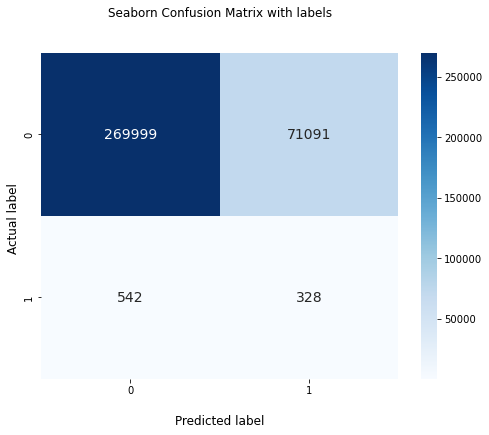

In [42]:
#Fill in optimal model parameters found in 2.1.2 
DT1 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10, max_features=None, min_samples_split=150, 
                             class_weight='balanced', random_state=random_state)
DT2 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10, max_features=None, min_samples_split=200, 
                             class_weight='balanced', random_state=random_state)
DT3 = DecisionTreeClassifier(random_state=random_state, max_features=10, class_weight='balanced', max_depth=None, min_samples_split=50)
DT4 = DecisionTreeClassifier(random_state=random_state, max_features=10, max_depth=5, min_samples_split=100)

#Model 1 - RU
start_time = time.time()
clf = DT1.fit(X_train_RU, y_train_RU)
y_pred1 = clf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#Model 2 - NM
start_time = time.time()
clf2 = DT2.fit(X_train_NM, y_train_NM)
y_pred2 = clf2.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#Model 3 - RUSBoost
start_time = time.time()
clf3 = RUSBoostClassifier(base_estimator=DT3, random_state=random_state).fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#Model 4 - UnderBagging
start_time = time.time()
clf4 = BalancedBaggingClassifier(random_state=random_state, base_estimator=DT4).fit(X_train, y_train)
y_pred4 = clf4.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 1 outcomes
print('Model 1 RU outcomes')
y_pred_proba = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba[:, 1]))
print(recall_score(y_test, y_pred1, average="binary", pos_label=1))
print(precision_score(y_test, y_pred1, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred1))
make_confusion_matrix(y_test, y_pred1)

#model 2 outcomes
print('Model 2 NM outcomes')
y_pred_proba2 = clf2.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba2[:, 1]))
print(recall_score(y_test, y_pred2, average="binary", pos_label=1))
print(precision_score(y_test, y_pred2, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred2))
make_confusion_matrix(y_test, y_pred2)

# #model 3 outcomes
print('Model 3 RUSBoost outcomes')
y_pred_proba3 = clf3.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba3[:, 1]))
print(recall_score(y_test, y_pred3, average="binary", pos_label=1))
print(precision_score(y_test, y_pred3, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred3))
make_confusion_matrix(y_test, y_pred3)

# #model 4 outcomes
print('Model 4 UnderBagging outcomes')
y_pred_proba4 = clf4.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba4[:, 1]))
print(recall_score(y_test, y_pred4, average="binary", pos_label=1))
print(precision_score(y_test, y_pred4, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred4))
make_confusion_matrix(y_test, y_pred4)

## 2.2 Random Forests

### 2.2.1 Find optimal Undersampled datasets

In [ ]:
#Find optimal Undersampled Training Data
model = RandomForestClassifier(random_state=random_state, class_weight= 'balanced')
X_train_NM, y_train_NM = do_undersampling_(model, 'NM', X_train, y_train)  
X_train_RU, y_train_RU = do_undersampling_(model, 'RU', X_train, y_train) 

### 2.2.2 Do hyperparameter optimization for two different models

In [ ]:
#Hyperparameter optimization
param_grid = {
    'criterion': ['entropy', 'gini', 'log_loss'],
    'max_depth': [None, 5, 10, 15],
    'max_features': [None, 5, 10, 15],
    'min_samples_split': [50, 100, 150],
    'n_estimators': [50, 100, 200],
    'class_weight': ['balanced', None]}

RF = RandomForestClassifier(random_state=random_state)
skf = StratifiedKFold(n_splits=5, shuffle = True)
grid_search = RandomizedSearchCV(estimator = RF, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                          n_iter=20, cv = skf, n_jobs = -1, verbose = 10)

#model 1 
start_time = time.time()
grid_search.fit(X_train_RU, y_train_RU)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print(grid_search.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

#model 2
start_time = time.time()
grid_search2 = RandomizedSearchCV(estimator = RF, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                          n_iter=20, cv = skf, n_jobs = -1, verbose = 10)
grid_search2.fit(X_train_NM, y_train_NM)
print(grid_search2.best_params_)
print('best score is ', grid_search2.best_score_)
print(grid_search2.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

### 2.2.3  Check Test Set Results

In [ ]:
#Fill in optimal model parameters found in 2.2.2 
RF1 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100, 
                            n_estimators = 200, class_weight = 'balanced', random_state=random_state)
RF2 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = None , min_samples_split = 200 , 
                               n_estimators = 100 , class_weight = 'balanced', random_state=random_state)

#Model 1 - RU
start_time = time.time()
clf = RF1.fit(X_train_RU, y_train_RU)
y_pred1 = clf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 2 - NM
start_time = time.time()
clf2 = RF2.fit(X_train_NM, y_train_NM)
y_pred2 = clf2.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 1 - RU - outcomes
print('Model 1 RU outcomes')
y_pred_proba = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba[:, 1]))
print(recall_score(y_test, y_pred1, average="binary", pos_label=1))
print(precision_score(y_test, y_pred1, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred1))
make_confusion_matrix(y_test, y_pred1)

#model 2 - NM - outcomes
print('Model 2 NM outcomes')
y_pred_proba2 = clf2.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba2[:, 1]))
print(recall_score(y_test, y_pred2, average="binary", pos_label=1))
print(precision_score(y_test, y_pred2, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred2))
make_confusion_matrix(y_test, y_pred2)

## 2.3 XGBoost

### 2.3.1 Find optimal Undersampled datasets

In [ ]:
#Find optimal Undersampled Training Data
model = XGBClassifier(random_state=random_state)
X_train_NM, y_train_NM = do_undersampling_(model, 'NM', X_train, y_train)  
X_train_RU, y_train_RU = do_undersampling_(model, 'RU', X_train, y_train) 

### 2.3.2 Do hyperparameter optimization for two different models

In [ ]:
#Hyperparameter optimization
param_grid = {
    'booster': ['gbtree', 'gblinear', 'dart'],
    'eta': [0.3, 0.4, 0.5, 0.6],
    'gamma': [5, 10, 15],
    'max_depth': [5, 10, 15, None],
    'subsample': [1],
    'sampling_method': ['uniform', 'gradient_based'],
    'lambda': [1],
    'alpha': [1],
    'tree_method': ['auto', 'approx', 'hist', 'gpu_hist'],
    'scale_pos_weight': [1, 10, 100]}

XG = XGBClassifier(random_state=random_state)
skf = StratifiedKFold(n_splits=5, shuffle = True)
grid_search = RandomizedSearchCV(estimator = XG, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                          n_iter=20, cv = skf, n_jobs = -1, verbose = 10)

#model 1 
start_time = time.time()
grid_search.fit(X_train_RU, y_train_RU)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print(grid_search.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

#model 2
start_time = time.time()
grid_search.fit(X_train_NM, y_train_NM)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print(grid_search.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

### 2.3.3  Check Test Set Results

In [ ]:
#Fill in optimal model parameters found in 2.3.2 
XG1 =  XGBClassifier(alpha=1, booster='gbtree', eta=0.3, gamma=10, max_depth =15, 
                   sampling_method = 'uniform', scale_pos_weight= 10, subsample= 1, tree_method= 'auto',
                   random_state=random_state)

XG2 =  XGBClassifier(alpha=1, booster='gbtree', eta=0.3, gamma=10, max_depth =10, 
                   sampling_method = 'uniform', scale_pos_weight= 10, subsample= 1, tree_method= 'auto',
                   random_state=random_state)

#model 1
start_time = time.time()
clf = XG1.fit(X_train_RU, y_train_RU)
y_pred1 = clf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 2
start_time = time.time()
clf2 = XG2.fit(X_train_NM, y_train_NM)
y_pred2 = clf2.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 1 outcomes
print('Model 1 RU outcomes')
y_pred_proba = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba[:, 1]))
print(recall_score(y_test, y_pred1, average="binary", pos_label=1))
print(precision_score(y_test, y_pred1, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred1))
make_confusion_matrix(y_test, y_pred1)

#model 2 outcomes
print('Model 2 NM outcomes')
y_pred_proba2 = clf2.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba2[:, 1]))
print(recall_score(y_test, y_pred2, average="binary", pos_label=1))
print(precision_score(y_test, y_pred2, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred2))
make_confusion_matrix(y_test, y_pred2)

## 2.4 Logistic Regression

### 2.4.1 Find optimal Undersampled datasets

In [ ]:
#Find optimal Undersampled Training Data
model = LogisticRegression(random_state=random_state)
X_train_NM, y_train_NM = do_undersampling_(model, 'NM', X_train, y_train)  
X_train_RU, y_train_RU = do_undersampling_(model, 'RU', X_train, y_train) 

### 2.4.2 Do hyperparameter optimization for four different models

In [ ]:
param_grid = {
    'penalty': ['l1', 'l2', None],
    'class_weight': ['balanced', None],
    'solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'C': [0.1, 0.5, 1, 2]}

param_grid2 = {
    'base_estimator__penalty': ['l1', 'l2', None],
    'base_estimator__solver': ['liblinear', 'lbfgs', 'newton-cg'],
    'base_estimator__C': [0.1, 0.5, 1, 2]}

LR = LogisticRegression(random_state=random_state)
skf = StratifiedKFold(n_splits=5, shuffle = True)

#model 1 - RU
start_time = time.time()
grid_search = RandomizedSearchCV(estimator = LR, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                          n_iter=20, cv = skf, n_jobs = -1, verbose = -1)
grid_search.fit(X_train_RU, y_train_RU)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print(grid_search.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

#model 2 - NM
start_time = time.time()
grid_search2 = RandomizedSearchCV(estimator = LR, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                          n_iter=20, cv = skf, n_jobs = -1, verbose = -1)
grid_search2.fit(X_train_NM, y_train_NM)
print(grid_search2.best_params_)
print('best score is ', grid_search2.best_score_)
print(grid_search2.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

#model 3 - RUSBoost
start_time = time.time()
LR = LogisticRegression(random_state=random_state)
grid_search3 = RandomizedSearchCV(RUSBoostClassifier(base_estimator=LR), param_distributions = param_grid2, 
                                     n_iter=20, scoring='balanced_accuracy', cv=skf, n_jobs=-1, verbose=-1)
grid_search3.fit(X_train, y_train)
print(grid_search3.best_params_)
print('best score is ', grid_search3.best_score_)
print(grid_search3.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

#model 4 - UnderBagging
start_time = time.time()
LR = LogisticRegression(random_state=random_state)
grid_search4 = RandomizedSearchCV(BalancedBaggingClassifier(base_estimator=LR), param_distributions = param_grid2, 
                                     n_iter=20, scoring='balanced_accuracy', cv=skf, n_jobs=-1, verbose=-1)
grid_search4.fit(X_train, y_train)
print(grid_search4.best_params_)
print('best score is ', grid_search4.best_score_)
print(grid_search4.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))


70 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\jan.deleeuw\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

--------

### 2.4.3  Check Test Set Results

In [ ]:
#Fill in optimal model parameters found in 2.4.2 
LR1 = LogisticRegression(penalty = 'l1' , class_weight = 'balanced', solver = 'liblinear', random_state=random_state, C=5)
LR2 = LogisticRegression(penalty = 'l2', class_weight = 'balanced', solver = 'lbfgs', random_state=random_state, C=1)
LR3 = LogisticRegression(penalty = 'l2' , solver = 'lbfgs', random_state=random_state, C=1)
LR4 = LogisticRegression(penalty = 'l2' , solver = 'lbfgs', random_state=random_state, C=5)

#model 1
start_time = time.time()
clf = LR1.fit(X_train_RU, y_train_RU)
y_pred1 = clf.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 2
start_time = time.time()
clf2 = LR2.fit(X_train_NM, y_train_NM)
y_pred2 = clf2.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 3 
start_time = time.time()
clf3 = RUSBoostClassifier(base_estimator=LR3, random_state=random_state).fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 4
start_time = time.time()
clf4 = BalancedBaggingClassifier(random_state=random_state, base_estimator=LR4).fit(X_train, y_train)
y_pred4 = clf4.predict(X_test)
print("--- %s seconds ---" % (time.time() - start_time))

#model 1 outcomes
print('Model 1 RU outcomes')
y_pred_proba = clf.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba[:, 1]))
print(recall_score(y_test, y_pred1, average="binary", pos_label=1))
print(precision_score(y_test, y_pred1, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred1))
make_confusion_matrix(y_test, y_pred1)

#model 2 outcomes
print('Model 2 NM outcomes')
y_pred_proba2 = clf2.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba2[:, 1]))
print(recall_score(y_test, y_pred2, average="binary", pos_label=1))
print(precision_score(y_test, y_pred2, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred2))
make_confusion_matrix(y_test, y_pred2)

#model 3 outcomes
print('Model 3 RU outcomes')
y_pred_proba3 = clf3.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba3[:, 1]))
print(recall_score(y_test, y_pred3, average="binary", pos_label=1))
print(precision_score(y_test, y_pred3, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred3))
make_confusion_matrix(y_test, y_pred3)

#model 4 outcomes
print('Model 4 NM outcomes')
y_pred_proba4 = clf4.predict_proba(X_test)
print(roc_auc_score(y_test, y_pred_proba4[:, 1]))
print(recall_score(y_test, y_pred4, average="binary", pos_label=1))
print(precision_score(y_test, y_pred4, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred4))
make_confusion_matrix(y_test, y_pred4)

## 2.5 Support Vector Machines

### 2.5.1 Do feature selection and scaling, normalization

In [135]:
#Define scaler and normalizer
scaler = MinMaxScaler()
normalizer = Normalizer()

#Define numerical features to normalize
numerical_features = ['weight', 'size_length', 'size_width', 'size_height', 'quantity', 'margin_invoice_price']

#Train scaler and normalizer
scaler.fit(X_train)
normalizer.fit(X_train[numerical_features])

#Perform scaling and normalizing
X_train[numerical_features] = normalizer.transform(X_train[numerical_features])
X_train_transformed = scaler.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns, index=X_train.index)
X_test[numerical_features] = normalizer.transform(X_test[numerical_features])
X_test_transformed = scaler.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test.columns, index=X_test.index)

In [136]:
# Do feature selection 
k = 50  #defines amount of features to select

# Initialize feature selector 
selector = SelectKBest(score_func=f_classif, k=k)
fit = selector.fit(X_train_transformed, y_train)  #should i do this on train data or all x-data. 

#Get feature selected data 
cols = selector.get_support(indices=True)
X_FS = X.iloc[:,cols]
X_train_FS = X_train_transformed.iloc[:,cols]
X_test_FS = X_test_transformed.iloc[:,cols]

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### 2.5.2 Find optimal Undersampled datasets

In [34]:
#Set undersampling strategy to reduce computational time
RU = RandomUnderSampler(sampling_strategy = 0.3, random_state=random_state)
NM = NearMiss(version=1, n_neighbors=3, sampling_strategy=0.3)
X_train_RU, y_train_RU = RU.fit_resample(X_train_FS, y_train)
X_train_NM, y_train_NM = NM.fit_resample(X_train_FS, y_train)

model = SVC(random_state=random_state)
# X_train_NM, y_train_NM = do_undersampling_(model, 'NM', X_train_FS, y_train)  
# X_train_RU, y_train_RU = do_undersampling_(model, 'RU', X_train_FS, y_train) 

### 2.5.3 Do hyperparameter optimization for four different models

In [ ]:
param_grid = {
    'C': [0.5, 1, 2],
    'kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'gamma': ['scale', 'auto'],
    'class_weight': ['balanced', None]}

param_grid2 = {
    'base_estimator__C': [0.5, 1, 2],
    'base_estimator__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
    'base_estimator__gamma': ['scale', 'auto'],

svc = SVC(random_state=random_state)
skf = StratifiedKFold(n_splits=3, shuffle = True)
grid_search = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                          n_iter=20, cv = skf, n_jobs = -1, verbose = -1)

#model 1 
start_time = time.time()
grid_search.fit(X_train_RU, y_train_RU)
print(grid_search.best_params_)
print('best score is ', grid_search.best_score_)
print(grid_search.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))
    
#model 2
start_time = time.time()
grid_search2 = RandomizedSearchCV(estimator = svc, param_distributions = param_grid, scoring = 'balanced_accuracy', 
                          n_iter=20, cv = skf, n_jobs = -1, verbose = -1)
grid_search2.fit(X_train_NM, y_train_NM)
print(grid_search2.best_params_)
print('best score is ', grid_search2.best_score_)
print(grid_search2.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))
    
#model 3
start_time = time.time()
svc = SVC(random_state=random_state)
grid_search3 = RandomizedSearchCV(RUSBoostClassifier(base_estimator=svc), param_distributions = param_grid2,  
                                     n_iter=20, scoring='balanced_accuracy', cv=skf, n_jobs=-1, verbose=-1)
grid_search3.fit(X_train_FS, y_train)
print(grid_search3.best_params_)
print('best score is ', grid_search3.best_score_)
print(grid_search3.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

#model 4
start_time = time.time()
svc = SVC(random_state=random_state)
grid_search4 = RandomizedSearchCV(BalancedBaggingClassifier(base_estimator=svc), param_distributions = param_grid2,  
                                     n_iter=20, scoring='balanced_accuracy', cv=skf, n_jobs=-1, verbose=-1)
grid_search4.fit(X_train_FS, y_train)
print(grid_search4.best_params_)
print('best score is ', grid_search4.best_score_)
print(grid_search4.cv_results_)
print("--- %s seconds ---" % (time.time() - start_time))

### 2.5.4  Check Test Set Results

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


--- 16.80062747001648 seconds ---
Model 2 NM outcomes
0.49729967308575374
0.8894009216589862
0.002567137973690161
0.5050067711504622


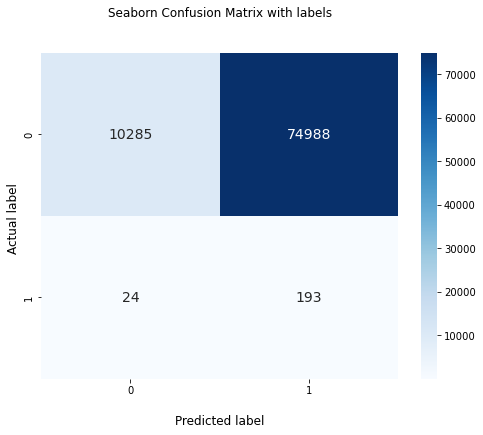

In [36]:
#Fill in optimal model parameters found in 2.4.2 
SVM1 = SVC(C = 1, kernel = 'rbf', gamma = 'scale', class_weight = None, random_state=random_state, probability=True)
SVM2 = SVC(C = 1, kernel = 'rbf', gamma = 'scale', class_weight = 'balanced', random_state=random_state, probability=True)
SVM3 = SVC(C = 1, kernel = 'rbf', gamma = 'scale', random_state=random_state, probability=True)
SVM4 = SVC(C = 1, kernel = 'rbf', gamma = 'scale', random_state=random_state, probability=True)

# #model 1
start_time = time.time()
clf = SVM1.fit(X_train_RU, y_train_RU)
y_pred1 = clf.predict(X_test_FS)
print("--- %s seconds ---" % (time.time() - start_time))

#model 2
start_time = time.time()
clf2 = SVM2.fit(X_train_NM, y_train_NM)
y_pred2 = clf2.predict(X_test_FS)
print("--- %s seconds ---" % (time.time() - start_time))

#model 3 
start_time = time.time()
clf3 = RUSBoostClassifier(base_estimator=SVM3, random_state=random_state).fit(X_train_FS, y_train)
y_pred3 = clf3.predict(X_test_FS)
print("--- %s seconds ---" % (time.time() - start_time))

#model 4
start_time = time.time()
clf4 = BalancedBaggingClassifier(random_state=random_state, base_estimator=SVM4).fit(X_train_FS, y_train)
y_pred4 = clf4.predict(X_test_FS)
print("--- %s seconds ---" % (time.time() - start_time))

model 1 outcomes
print('Model 1 RU outcomes')
y_pred_proba = clf.predict_proba(X_test_FS)
print(roc_auc_score(y_test, y_pred_proba[:, 1]))
print(recall_score(y_test, y_pred1, average="binary", pos_label=1))
print(precision_score(y_test, y_pred1, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred1))
make_confusion_matrix(y_test, y_pred1)

#model 2 outcomes
print('Model 2 NM outcomes')
y_pred_proba2 = clf2.predict_proba(X_test_FS)
print(roc_auc_score(y_test, y_pred_proba2[:, 1]))
print(recall_score(y_test, y_pred2, average="binary", pos_label=1))
print(precision_score(y_test, y_pred2, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred2))
make_confusion_matrix(y_test, y_pred2)

#model 3 outcomes
print('Model 3 RU outcomes')
y_pred_proba3 = clf3.predict_proba(X_test_FS)
print(roc_auc_score(y_test, y_pred_proba3[:, 1]))
print(recall_score(y_test, y_pred3, average="binary", pos_label=1))
print(precision_score(y_test, y_pred3, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred3))
make_confusion_matrix(y_test, y_pred3)

#model 4 outcomes
print('Model 4 NM outcomes')
y_pred_proba4 = clf4.predict_proba(X_test_FS)
print(roc_auc_score(y_test, y_pred_proba4[:, 1]))
print(recall_score(y_test, y_pred4, average="binary", pos_label=1))
print(precision_score(y_test, y_pred4, average="binary", pos_label=1))
print(balanced_accuracy_score(y_test, y_pred4))
make_confusion_matrix(y_test, y_pred4)

## 2.6 Compare performance of all classifiers & Obtain Costs

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[[71177 14096]
 [   93   124]]
DT costs are 55318.020000000004
Total misclassification costs are  65964.62


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


[[77078  8195]
 [  112   105]]
RF costs are 51867.76
Total misclassification costs are  60948.049999999996
[[58730 26543]
 [   63   154]]
XGB costs are 66023.58
Total misclassification costs are  78615.59


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations 

[[63345 21928]
 [   74   143]]
LR costs are 62012.36
Total misclassification costs are  76110.56999999999


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[[70993 14280]
 [  102   115]]
SVM costs are 58688.759999999995
Total misclassification costs are  70158.03


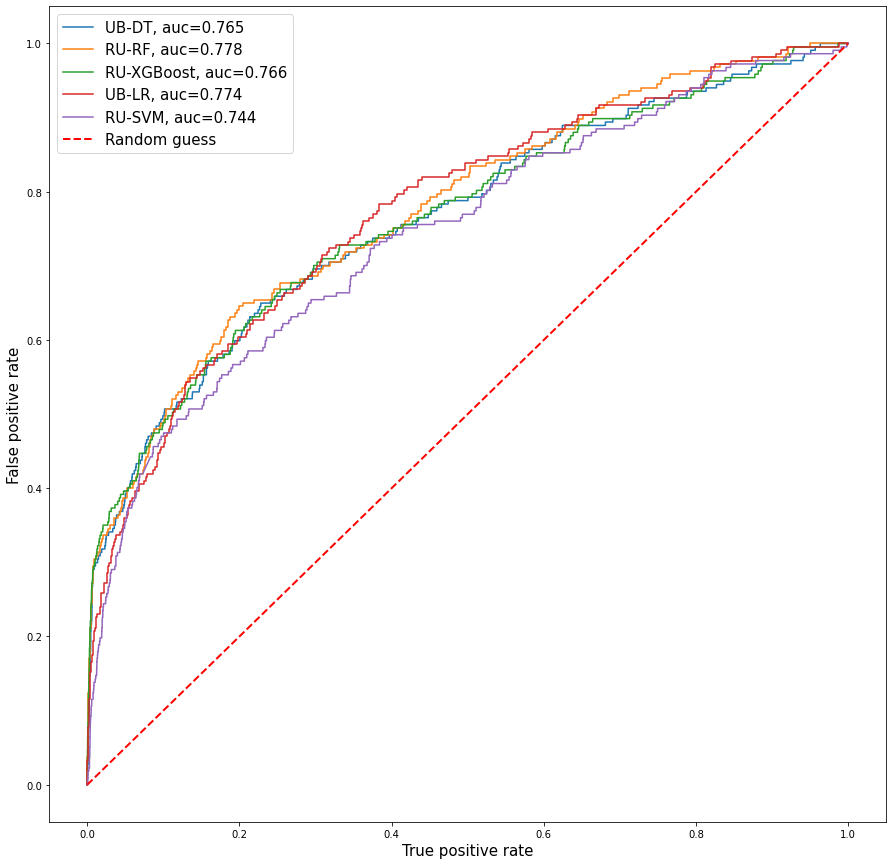

In [164]:
#parameters to choose
random_state = 1
np.random.seed(random_state)
sampling_strategy_RU = 0.3  #Fill in after finding optimal

#import data
X = pd.read_csv('X_modeling2.csv', index_col = 0)
y = pd.read_csv('y_modeling2.csv', index_col = 0)
X = X.drop('parent_securityshipment_Insurance', axis=1)
X = X.drop('parent_securityshipment_None', axis=1)
X = X.drop('parent_securityshipment_Signature', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=random_state)
RU = RandomUnderSampler(sampling_strategy = sampling_strategy_RU)             
X_train_RU, y_train_RU = RU.fit_resample(X_train, y_train)


fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

#DT
DT1 = DecisionTreeClassifier(random_state=random_state, class_weight='balanced', max_features=10, max_depth=None, min_samples_split=50)
DT = BalancedBaggingClassifier(base_estimator=DT1, random_state=random_state).fit(X_train, y_train)
y_pred2 = DT.predict(X_test)
print(confusion_matrix(y_test, y_pred2))
print('DT costs are', calculate_cost(y_test, y_pred2))
y_pred_proba2 = DT.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba2[:, 1])
auc_ = roc_auc_score(y_test, y_pred_proba2[:, 1])
ax.plot(fpr, tpr,label="UB-DT, auc="+str(round(auc_,3)))
cost_test_set(X_test, y_test, y_pred2)


#RF
RF1 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100, 
                            n_estimators = 200, class_weight = 'balanced', random_state=random_state)
clf2 = RF1.fit(X_train_RU, y_train_RU)
y_pred2 = clf2.predict(X_test)
print(confusion_matrix(y_test, y_pred2))
print('RF costs are', calculate_cost(y_test, y_pred2))
y_pred_proba2 = clf2.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba2[:, 1])
auc_ = roc_auc_score(y_test, y_pred_proba2[:, 1])
ax.plot(fpr, tpr,label="RU-RF, auc="+str(round(auc_,3)))
cost_test_set(X_test, y_test, y_pred2)

#XGBoost
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=1)
RU = RandomUnderSampler(sampling_strategy = 0.3)
X_train_RU, y_train_RU = RU.fit_resample(X_train, y_train)
XG1 =  XGBClassifier(alpha=1, booster='gbtree', eta=0.3, gamma=10, max_depth =15, 
                   sampling_method = 'uniform', scale_pos_weight= 10, subsample= 1, tree_method= 'auto',
                   random_state=random_state)
clf2 = XG1.fit(X_train_RU, y_train_RU)
y_pred2 = clf2.predict(X_test)
print(confusion_matrix(y_test, y_pred2))
print('XGB costs are', calculate_cost(y_test, y_pred2))
y_pred_proba2 = clf2.predict_proba(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba2[:, 1])
auc_ = roc_auc_score(y_test, y_pred_proba2[:, 1])
ax.plot(fpr, tpr,label="RU-XGBoost, auc="+str(round(auc_,3)))
cost_test_set(X_test, y_test, y_pred2)

#LR
LR4 = LogisticRegression(penalty = 'l2' , solver = 'lbfgs', random_state=random_state, C=5)
clf2 = BalancedBaggingClassifier(random_state=random_state, base_estimator=LR4).fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
y_pred_proba2 = clf2.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred2))
print('LR costs are', calculate_cost(y_test, y_pred2))
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba2[:, 1])
auc_ = roc_auc_score(y_test, y_pred_proba2[:, 1])
ax.plot(fpr, tpr,label="UB-LR, auc="+str(round(auc_,3)))
cost_test_set(X_test, y_test, y_pred2)


#SVM
X_train_RU, y_train_RU = RU.fit_resample(X_train_FS, y_train)
SVC2 = SVC(C = 1, kernel = 'rbf', gamma = 'scale', class_weight = 'balanced', random_state=random_state, probability=True)
clf2 = SVC2.fit(X_train_RU, y_train_RU)
y_pred2 = clf2.predict(X_test_FS)
print(confusion_matrix(y_test, y_pred2))
print('SVM costs are', calculate_cost(y_test, y_pred2))
y_pred_proba2 = clf2.predict_proba(X_test_FS)
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba2[:, 1])
auc_ = roc_auc_score(y_test, y_pred_proba2[:, 1])
ax.plot(fpr, tpr,label="RU-SVM, auc="+str(round(auc_,3)))
cost_test_set(X_test, y_test, y_pred2)

#NOG de 
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
ax.set_xlabel('True positive rate', fontsize=15)
ax.set_ylabel("False positive rate", fontsize=15)
ax.legend(loc=0, fontsize=15)
fig.savefig('ROC-AUCS.png', dpi=300)

In [45]:
### Determine mean performance and sd of all classifiers:

recall_DT = []
precision_DT = []
BA_DT = []
ROC_AUC_DT = []
recall_RF = []
precision_RF = []
BA_RF = []
ROC_AUC_RF = []
recall_XGB = []
precision_XGB = []
BA_XGB = []
ROC_AUC_XGB = []
recall_LR = []
precision_LR = []
BA_LR = []
ROC_AUC_LR = []
for j in [0,1,2,3,4,5,6,7,8,9]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=j)

    RU = RandomUnderSampler(sampling_strategy=0.3, random_state=j) #Manually set sampling strategy
    X_train_RU, y_train_RU = RU.fit_resample(X_train, y_train)

    #RF
    RF1 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100, 
                        n_estimators = 200, class_weight = 'balanced', random_state=j)
    recall, prec, ba, ROC_AUC = evaluate_classifier_validate(RF, X_train_RU, y_train_RU, X_test, y_test, SVM=False)
    recall_RF.append(recall)
    precision_RF.append(prec)
    BA_RF.append(ba)
    ROC_AUC_RF.append(ROC_AUC)

    #DT
    DT1 = DecisionTreeClassifier(criterion = 'entropy', max_depth=10, max_features=None, min_samples_split=150, 
                         class_weight='balanced', random_state=j)
    recall, prec, ba, ROC_AUC = evaluate_classifier_validate(DT, X_train_RU, y_train_RU, X_test, y_test, SVM=False)
    recall_DT.append(recall)
    precision_DT.append(prec)
    BA_DT.append(ba)
    ROC_AUC_DT.append(ROC_AUC)

    #XGB
    XG1 =  XGBClassifier(alpha=1, booster='gbtree', eta=0.3, gamma=10, max_depth =15, 
               sampling_method = 'uniform', scale_pos_weight= 10, subsample= 1, tree_method= 'auto',
               random_state=j)
    recall, prec, ba, ROC_AUC = evaluate_classifier_validate(XG1, X_train_RU, y_train_RU, X_test, y_test, SVM=False)
    recall_XGB.append(recall)
    precision_XGB.append(prec)
    BA_XGB.append(ba)
    ROC_AUC_XGB.append(ROC_AUC)

    #LR
    LR1 = LogisticRegression(penalty = 'l1' , class_weight = 'balanced', solver = 'liblinear', random_state=j, C=5)
    recall, prec, ba, ROC_AUC = evaluate_classifier_validate(LR1, X_train_RU, y_train_RU, X_test, y_test, SVM=False)
    recall_LR.append(recall)
    precision_LR.append(prec)
    BA_LR.append(ba)
    ROC_AUC_LR.append(ROC_AUC)

print('Results RF are. Mean recall {}, std recall {}. Mean precision {}, std recall {}. Mean BA = {}, std BA = {}, mean ROC_AUC = {}, std ROC_AUC = {}'.format(
np.mean(recall_RF), np.std(recall_RF), np.mean(precision_RF), np.std(precision_RF), np.mean(BA_RF), np.std(BA_RF),np.mean(ROC_AUC_RF), np.std(ROC_AUC_RF)))

print('Results DT are. Mean recall {}, std recall {}. Mean precision {}, std recall {}. Mean BA = {}, std BA = {}, mean ROC_AUC = {}, std ROC_AUC = {}'.format(
np.mean(recall_DT), np.std(recall_DT), np.mean(precision_DT), np.std(precision_DT), np.mean(BA_DT), np.std(BA_DT),np.mean(ROC_AUC_DT), np.std(ROC_AUC_DT)))

print('Results XGB are. Mean recall {}, std recall {}. Mean precision {}, std recall {}. Mean BA = {}, std BA = {}, mean ROC_AUC = {}, std ROC_AUC = {}'.format(
np.mean(recall_XGB), np.std(recall_XGB), np.mean(precision_XGB), np.std(precision_XGB), np.mean(BA_XGB), np.std(BA_XGB),np.mean(ROC_AUC_XGB), np.std(ROC_AUC_XGB)))

print('Results LR are. Mean recall {}, std recall {}. Mean precision {}, std recall {}. Mean BA = {}, std BA = {}, mean ROC_AUC = {}, std ROC_AUC = {}'.format(
np.mean(recall_LR), np.std(recall_LR), np.mean(precision_LR), np.std(precision_LR), np.mean(BA_LR), np.std(BA_LR),np.mean(ROC_AUC_LR), np.std(ROC_AUC_LR)))



A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change

Results RF are. Mean recall 0.4783410138248848, std recall 0.026854935086328965. Mean precision 0.011249408427531147, std recall 0.0007407914806845825. Mean BA = 0.6855245697459301, std BA = 0.012348062919365486, mean ROC_AUC = 0.7618870668621318, std ROC_AUC = 0.014587014632513084
Results DT are. Mean recall 0.5483870967741936, std recall 0.0350957285984512. Mean precision 0.008275715789404527, std recall 0.00042107035014645665. Mean BA = 0.6906049564529558, std BA = 0.016171495610371508, mean ROC_AUC = 0.7590052761418314, std ROC_AUC = 0.016219228048911807
Results XGB are. Mean recall 0.6599078341013824, std recall 0.027787674528444863. Mean precision 0.0054342939177633946, std recall 0.00019591027138464597. Mean BA = 0.6761707734999777, std BA = 0.010769155567336887, mean ROC_AUC = 0.7510676093118329, std ROC_AUC = 0.017289348927233637
Results LR are. Mean recall 0.6276497695852534, std recall 0.030414746543778813. Mean precision 0.006191698862477421, std recall 0.000285159861825279

## 2.7 Validation-test set analysis 

In [41]:
# Defines ratios, w.r.t. whole dataset.
ratio_train = [0.9, 0.8, 0.7, 0.6]
ratio_test = [0.1, 0.2, 0.3, 0.4] 

###### OUTCOMES FOR RF MODEL 

for i in [0,1,2,3]:
    print('RESULTS FOR Ratio train {}, test {}'.format(ratio_train[i], ratio_test[i]))
    recall_RF = []
    precision_RF = []
    BA_RF = []
    ROC_AUC_RF = []
    
    for j in range(19):
        #Define train validate and test sets 
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=ratio_test[i], random_state=j)

        #Train optimal model 
        RU = RandomUnderSampler(sampling_strategy=0.3, random_state=random_state) #Manually set sampling strategy
        X_train_RU, y_train_RU = RU.fit_resample(X_train, y_train)

        #Define optimal found model  
        RF1 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100, 
                            n_estimators = 200, class_weight = 'balanced', random_state=random_state)

        
        recall, prec, ba, ROC_AUC = evaluate_classifier_validate(RF, X_train_RU, y_train_RU, X_test, y_test, SVM=False)
        recall_RF.append(recall)
        precision_RF.append(prec)
        BA_RF.append(ba)
        ROC_AUC_RF.append(ROC_AUC)
        
    print('Results RF are. Mean recall {}, std recall {}. Mean precision {}, std recall {}. Mean BA = {}, std BA = {}, mean ROC_AUC = {}, std ROC_AUC = {}'.format(
    np.mean(recall_RF), np.std(recall_RF), np.mean(precision_RF), np.std(precision_RF), np.mean(BA_RF), np.std(BA_RF),np.mean(ROC_AUC_RF), np.std(ROC_AUC_RF)))

RESULTS FOR Ratio train 0.9, test 0.1


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Results RF are. Mean recall 0.45622119815668194, std recall 0.03346550064443695. Mean precision 0.012163866985803266, std recall 0.0012275935395156014. Mean BA = 0.6807842719321535, std BA = 0.017756476462953866, mean ROC_AUC = 0.7603392364855285, std ROC_AUC = 0.02305040269098137
RESULTS FOR Ratio train 0.8, test 0.2


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Results RF are. Mean recall 0.46182698124621907, std recall 0.02094876716028739. Mean precision 0.012322114034397567, std recall 0.0008872622648455308. Mean BA = 0.6834984697380522, std BA = 0.010010513494468739, mean ROC_AUC = 0.7618340756867191, std ROC_AUC = 0.013887802255194384
RESULTS FOR Ratio train 0.7, test 0.3


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Results RF are. Mean recall 0.4589925734581853, std recall 0.022986441389450708. Mean precision 0.012530676045284116, std recall 0.00079716638889713. Mean BA = 0.6832167771599952, std BA = 0.009952504397686607, mean ROC_AUC = 0.7593960345476177, std ROC_AUC = 0.009116662580119846
RESULTS FOR Ratio train 0.6, test 0.4


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

Results RF are. Mean recall 0.45359951603145793, std recall 0.02049111747952169. Mean precision 0.012556431427005344, std recall 0.0007839049038846427. Mean BA = 0.6810492924031649, std BA = 0.006945127080909052, mean ROC_AUC = 0.7585685039263383, std ROC_AUC = 0.007175062445417133


# 3. Semi-Supervised Machine learning 

### 3.1.1 Import data

In [172]:
X = pd.read_csv('X_modeling2.csv', index_col = 0)
y = pd.read_csv('y_modeling2.csv', index_col = 0)
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]
X_to_join = X.copy()
X_to_join = X_to_join.reset_index()
y_to_join = pd.DataFrame(y)
y_to_join = y_to_join.reset_index()
df = pd.concat([X_to_join, y_to_join], axis=1)
df = df.drop(['index'], axis=1)
X = X.drop('parent_securityshipment_Insurance', axis=1)
X = X.drop('parent_securityshipment_None', axis=1)
X = X.drop('parent_securityshipment_Signature', axis=1)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=ratio_test, random_state=random_state)
y_test.value_counts()

Is_lost_item
0               85273
1                 217
dtype: int64

In [173]:
#Repeat parameters
number_of_features = 25
mean_stock_value = 340.18
mean_insurance_costs = 1.68
random_state = 1
np.random.seed(random_state)
ratio_train = 0.9
ratio_test = 0.1
cost_scorer = make_scorer(calculate_cost, greater_is_better = False)   #Define own scoring function

### 3.1.2 List all features on importance from RF model

In [174]:
#List the features on feature importance according to best model supervised
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=random_state)
X_train_RU, y_train_RU = RandomUnderSampler(random_state= random_state, sampling_strategy=0.3).fit_resample(X_train, y_train)

#Best model supervised
RF = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100, 
                            n_estimators = 200, class_weight = 'balanced', random_state=random_state).fit(X_train_RU, y_train_RU)

feature_importances = RF.feature_importances_
feature_list = list(X_train_RU.columns)
relative_importances = pd.DataFrame(index=feature_list, data=feature_importances, columns=["importance"])
relative_importances = relative_importances.sort_values(by="importance", ascending=False)
most_important_features_df = pd.DataFrame(relative_importances, columns = ['col_name', 'importance'])
most_important_features_df = most_important_features_df.reset_index(inplace=False)
most_important_features = most_important_features_df['index'].values


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


### 3.1.3 Split data in train, validation and test 

In [175]:
#Get features 
FS_most = list(most_important_features)
feat = FS_most[:number_of_features] + ['Is_lost_item']
df2 = df[feat]
LOST = df2[df2.Is_lost_item == 1]
NORMAL = df2[df2.Is_lost_item == 0]

In [176]:
### 80/10/10  and 0/90/10 split
X_train, Remaining_normal = train_test_split(NORMAL, train_size = 0.8, random_state=random_state)
X_train = X_train.drop('Is_lost_item', axis=1)

Remaining = Remaining_normal.append(LOST)

REMAINING_Y = Remaining['Is_lost_item']
REMAINING_X = Remaining.drop('Is_lost_item', axis=1)

X_to_join = REMAINING_X.copy()
X_to_join = X_to_join.reset_index()
y_to_join = pd.DataFrame(REMAINING_Y)
y_to_join = y_to_join.reset_index()
df = pd.concat([X_to_join, y_to_join], axis=1)
df = df.drop(['index'], axis=1)
df.shape

REMAINING_LOST = df[df.Is_lost_item == 1]
REMAINING_NORMAL = df[df.Is_lost_item == 0]

REMAINING_LOST_Y = REMAINING_LOST['Is_lost_item']
REMAINING_LOST_X = REMAINING_LOST.drop('Is_lost_item', axis=1)

REMAINING_NORMAL_Y = REMAINING_NORMAL['Is_lost_item']
REMAINING_NORMAL_X = REMAINING_NORMAL.drop('Is_lost_item', axis=1)

X_validate_LOST, X_test_LOST, y_validate_LOST, y_test_LOST = train_test_split(REMAINING_LOST_X, REMAINING_LOST_Y, train_size=0.9, random_state=random_state)
X_validate_NORMAL, X_test_NORMAL, y_validate_NORMAL, y_test_NORMAL = train_test_split(REMAINING_NORMAL_X, REMAINING_NORMAL_Y, train_size=0.5, random_state=random_state)

X_validate = X_validate_LOST.append(X_validate_NORMAL, ignore_index=True)
X_test = X_test_LOST.append(X_test_NORMAL, ignore_index=True)
y_validate = y_validate_LOST.append(y_validate_NORMAL, ignore_index=True)
y_test = y_test_LOST.append(y_test_NORMAL, ignore_index=True)

print(f"""Shape of the datasets:
    training (rows, cols) = {X_train.shape}
    validate (rows, cols) = {X_validate.shape}
    holdout  (rows, cols) = {X_test.shape}""")

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Shape of the datasets:
    training (rows, cols) = (682179, 25)
    validate (rows, cols) = (87228, 25)
    holdout  (rows, cols) = (85491, 25)


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [41]:
y_test.value_counts()

0    85273
1      218
Name: Is_lost_item, dtype: int64

## 3.2 Data Normalization and Standardization

In [177]:
normalized_features = ['quantity', 'stock_value', 'size_height','weight', 'size_width', 'size_length ', 'margin_invoice_price']

feats = []
for i in feat:
    if i not in normalized_features:
        feats.append(i)
feats.remove('Is_lost_item')

scaler = MinMaxScaler()
normalizer = Normalizer() 

scaler.fit(X_train)
normalizer.fit(X_train[feats])

X_train[feats] = normalizer.transform(X_train[feats])
X_train_transformed = scaler.transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, columns=X_train.columns, index=X_train.index)

X_validate[feats] = normalizer.transform(X_validate[feats])
X_validate_transformed = scaler.transform(X_validate)
X_validate_transformed = pd.DataFrame(X_validate_transformed, columns=X_validate.columns, index=X_validate.index)

X_test[feats] = normalizer.transform(X_test[feats])
X_test_transformed = scaler.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=X_test.columns, index=X_test.index)

X_train_transformed.to_csv('X_train_transformed.csv')
X_validate_transformed.to_csv('X_validate_transformed.csv')
X_test_transformed.to_csv('X_test_transformed.csv')
y_test.to_csv('y_test.csv')
y_validate.to_csv('y_validate.csv')

In [30]:
y_test.value_counts()

0    85273
1      218
Name: Is_lost_item, dtype: int64

## 3.3 Regular Autoencoder

### 3.3.1 Create Autoencoder

In [10]:
#Parameters to set 
BATCH_SIZE = 2000
EPOCHS = 20
input_dim = X_train_transformed.shape[1]
autoencoder = create_model()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 208       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 8)                 40        
                                                                 
 dense_4 (Dense)          

In [11]:
# current date and time
yyyymmddHHMM = datetime.now().strftime('%Y%m%d%H%M')

# new folder for a new run
log_subdir = f'{yyyymmddHHMM}_batch{BATCH_SIZE}_layers{len(autoencoder.layers)}'

# define our early stopping
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=50,
    verbose=1, 
    mode='min',
    restore_best_weights=True
)

save_model = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.hdf5',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)

tensorboard = tf.keras.callbacks.TensorBoard(
    f'logs/{log_subdir}',
    batch_size=BATCH_SIZE,
    update_freq='batch'
)

# callbacks argument only takes a list
cb = [early_stop, save_model, tensorboard]

### 3.3.2 Train autoencoder

Epoch 1/20
307/307 [==============================] - 3s 7ms/step - loss: 0.0224 - mse: 0.0224 - auc: 0.7201 - accuracy: 0.2513 - val_loss: 0.0196 - val_mse: 0.0196 - val_auc: 0.7486 - val_accuracy: 0.2906
Epoch 2/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0195 - mse: 0.0195 - auc: 0.7453 - accuracy: 0.2908 - val_loss: 0.0193 - val_mse: 0.0193 - val_auc: 0.7461 - val_accuracy: 0.2906
Epoch 3/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0192 - mse: 0.0192 - auc: 0.7461 - accuracy: 0.2908 - val_loss: 0.0192 - val_mse: 0.0192 - val_auc: 0.7474 - val_accuracy: 0.2906
Epoch 4/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0191 - mse: 0.0191 - auc: 0.7484 - accuracy: 0.2908 - val_loss: 0.0191 - val_mse: 0.0191 - val_auc: 0.7505 - val_accuracy: 0.2906
Epoch 5/20
307/307 [==============================] - 2s 6ms/step - loss: 0.0191 - mse: 0.0191 - auc: 0.7495 - accuracy: 0.2908 - val_loss: 0.0190 - val_mse: 0.0190 - val_auc: 

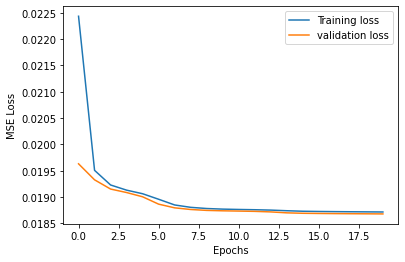

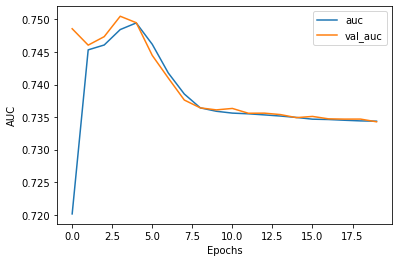

In [213]:
X_train_train_transformed, X_train_validate_transformed = train_test_split(X_train_transformed, 
                                                                        train_size = 0.9, random_state=random_state)
start_time = time.time()
history = autoencoder.fit(
    X_train_train_transformed, X_train_train_transformed,
    shuffle=True,
    epochs=20,
    batch_size=BATCH_SIZE,
    #callbacks=cb,
    validation_data=(X_train_validate_transformed, X_train_validate_transformed))
print("--- %s seconds ---" % (time.time() - start_time))
plot_metrics(history)

### 3.3.3 See plots of reconstruction error

2726/2726 [==============================] - 3s 1ms/step


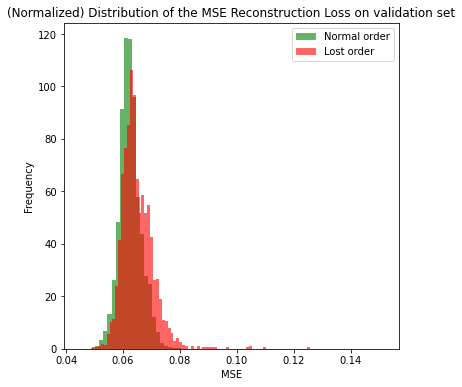

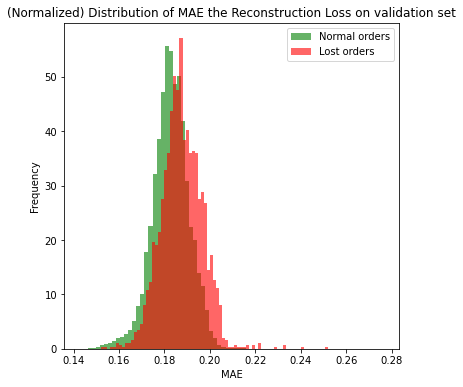

In [180]:
# Pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_validate_transformed)

# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)

clean_mse = mse[y_validate== 0]
fraud_mse = mse[y_validate== 1]
clean_mae = mae[y_validate== 0]
fraud_mae = mae[y_validate== 1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean_mse, bins=75, density=True, label="Normal order", alpha=.6, color="green")
ax.hist(fraud_mse, bins=75, density=True, label="Lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the MSE Reconstruction Loss on validation set")
plt.xlabel('MSE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean_mae, bins=75, density=True, label="Normal orders", alpha=.6, color="green")
ax.hist(fraud_mae, bins=75, density=True, label="Lost orders", alpha=.6, color="red")

plt.title("(Normalized) Distribution of MAE the Reconstruction Loss on validation set")
plt.xlabel('MAE')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 3.3.4 Results with Threshold via Z-scores on validation set 

In [181]:
THRESHOLD = 1.00

#MAE
z_scores = mad_score(mae)
outliers = z_scores > THRESHOLD
print(f"MAE Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

#MSE
z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD
print(f"MSE Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

MAE Detected 28,871 outliers in a total of 87,228 transactions [33.10%].
MSE Detected 29,372 outliers in a total of 87,228 transactions [33.67%].


optimal threshold for MAE = 0.9800000000000004 with accuracy = 0.5663799335450269
optimal threshold for MSE = 1.4300000000000008 with accuracy = 0.5760711159151775
--- 2.1568715572357178 seconds ---
Results on the validation set, with chosen z-score threshold =  1.4300000000000008
ROC is  0.6425718765750152
The classifications using the MAD method on validation set with threshold=1.4300000000000008 are as follows:
[[68688 16584]
 [ 1278   678]]
# % of transactions labeled as fraud that were correct (precision): 678/(16584+678) = 3.93%
# % of fraudulent transactions were caught succesfully (recall):    678/(1278+678) = 34.66%
Balanced accuracy =  0.5760711159151775
              precision    recall  f1-score   support

           0       0.98      0.81      0.88     85272
           1       0.04      0.35      0.07      1956

    accuracy                           0.80     87228
   macro avg       0.51      0.58      0.48     87228
weighted avg       0.96      0.80      0.87     87228



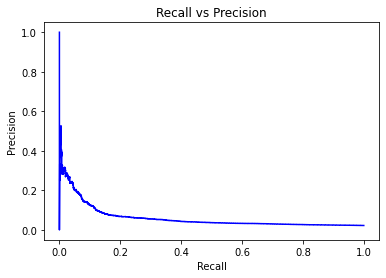

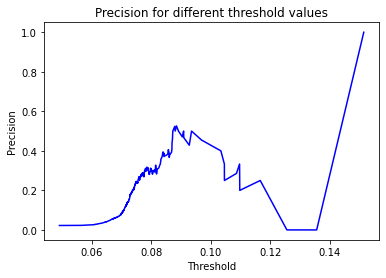

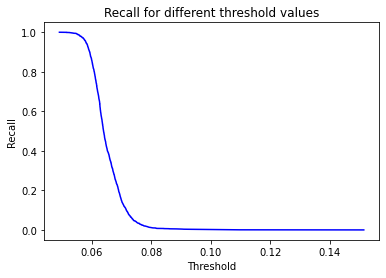

In [182]:
from sklearn.metrics import roc_auc_score, auc

#Setting a supervised threshold via Z-scores on training set. 
threshold = [] 
accuracy_mae = []
accuracy_mse = []
start_time = time.time()
for p in np.arange(start=0.5, stop=1.5, step=0.01):       
    z_scores_mae = mad_score(mae)
    z_scores_mse = mad_score(mse)
    outliers_mse = z_scores_mse > p 
    outliers_mae = z_scores_mae > p
    accuracy_mae.append(balanced_accuracy_score(y_validate, outliers_mae))
    accuracy_mse.append(balanced_accuracy_score(y_validate, outliers_mse))
    threshold.append(p) 
    
ix_1 = argmax(accuracy_mae)    
ix_2 = argmax(accuracy_mse)
th_1 = threshold[ix_1]
th_2 = threshold[ix_2]
print('optimal threshold for MAE = {} with accuracy = {}'.format(th_1, accuracy_mae[ix_1]))
print('optimal threshold for MSE = {} with accuracy = {}'.format(th_2, accuracy_mse[ix_2]))
print("--- %s seconds ---" % (time.time() - start_time))
if accuracy_mae[ix_1] > accuracy_mse[ix_2]:
    threshold = threshold[ix_1]
    z_scores = mad_score(mae)
    outliers = z_scores > threshold
    mode = 'mae'
else:
    threshold = threshold[ix_2]
    z_scores = mad_score(mse)
    outliers = z_scores > threshold
    mode = 'mse'

#print results 
print('Results on the validation set, with chosen z-score threshold = ', threshold)
cm = confusion_matrix(y_validate, outliers)
BA = balanced_accuracy_score(y_validate, outliers)
CR = classification_report(y_validate, outliers)
if mode == 'mse': 
    error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_validate})
else: 
    error_df = pd.DataFrame({'reconstruction_error': mae, 'true_class': y_validate})
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method on validation set with threshold={threshold} are as follows:
{cm}
# % of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
# % of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
print('Balanced accuracy = ', BA)
print(CR)

#Some plots
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

2672/2672 [==============================] - 3s 1ms/step


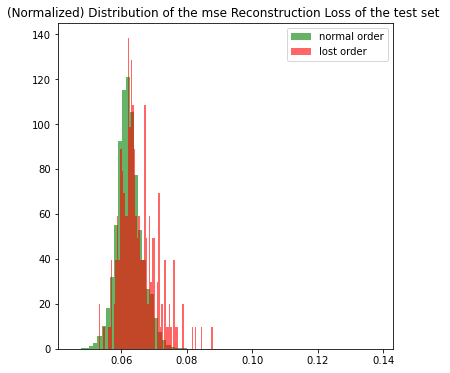

Results on the test set, with chosen z-score threshold =  1.4300000000000008
ROC is  0.6416195980163871
The classifications using the MAD method on validation set with threshold=1.4300000000000008 are as follows:
[[68549 16724]
 [  136    82]]

# % of transactions labeled as fraud that were correct (precision): 82/(16724+82) = 0.49%
# % of fraudulent transactions were caught succesfully (recall):    82/(136+82) = 37.61%
Balanced accuracy =  0.5900118744363085
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     85273
           1       0.00      0.38      0.01       218

    accuracy                           0.80     85491
   macro avg       0.50      0.59      0.45     85491
weighted avg       1.00      0.80      0.89     85491



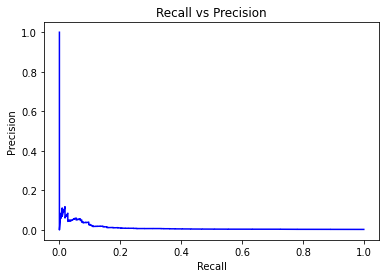

In [183]:
# Test set results
# Pass the transformed validation set through the autoencoder to get the reconstructed result
reconstructions = autoencoder.predict(X_test_transformed)

# calculating the mean squared error reconstruction loss per row in the numpy array
if mode == 'mse':
    mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
    clean = mse[y_test==0]
    fraud = mse[y_test ==1]
    z_scores = mad_score(mse)
    outliers = z_scores > threshold
else: 
    mae = np.mean(np.absolute(X_test_transformed - reconstructions), axis=1)
    clean = mae[y_test==0]
    fraud = mae[y_test ==1]
    z_scores = mad_score(mae)
    outliers = z_scores > threshold
    
#Make plot of reconstruction errors 
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud, bins=75, density=True, label="lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the {} Reconstruction Loss of the test set ".format(mode))
plt.legend()
plt.show()

print('Results on the test set, with chosen z-score threshold = ', threshold)
cm = confusion_matrix(y_test, outliers)
BA = balanced_accuracy_score(y_test, outliers)
CR = classification_report(y_test, outliers)
if mode == 'mse': 
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_test})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method on validation set with threshold={threshold} are as follows:
{cm}

# % of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
# % of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
print('Balanced accuracy = ', BA)
print(CR)

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

2726/2726 [==============================] - 3s 1ms/step


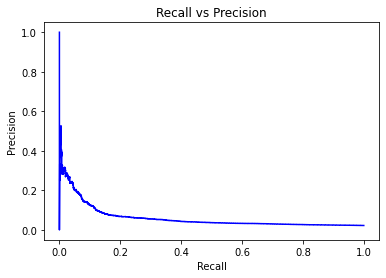

<AxesSubplot:xlabel='threshold', ylabel='value'>

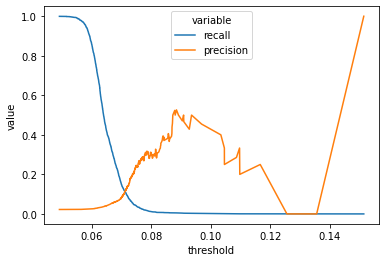

In [184]:
#precision recall curve on validation set 
reconstructions = autoencoder.predict(X_validate_transformed)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_validate})

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

#plot 1
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#plot 2
val_prt = pd.DataFrame({
    "threshold": th,
    "recall": recall[1:],
    "precision": precision[1:]})
val_prt_melted = pd.melt(val_prt, id_vars = ["threshold"], value_vars = ["recall", "precision"])
sns.lineplot(x = "threshold", y = "value", hue = "variable", data = val_prt_melted)

2726/2726 [==============================] - 3s 1ms/step


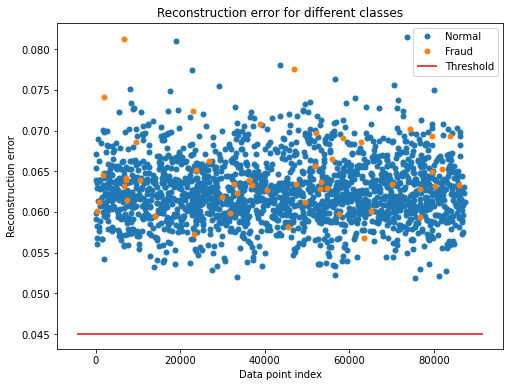

In [185]:
#Reconstruction with threshold plot
reconstructions = autoencoder.predict(X_validate_transformed)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_validate})
error_df_shuffled = error_df.sample(frac=1).reset_index()

#plot 
df2 = error_df_shuffled.sample(n=2000)
groups = df2.groupby('true_class')
fig, ax = plt.subplots(figsize=(8,6))
for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=5.0, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(0.045, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

### 3.3.5 Results with threshold via balanced accuracy optimization on validation set 

2726/2726 [==============================] - 3s 1ms/step
0.06253477894391209
ROC is  0.6425718765750152
--- 24.77198576927185 seconds ---
optimal threshold = 0.0625999999999998 with accuracy = 0.602169161174318


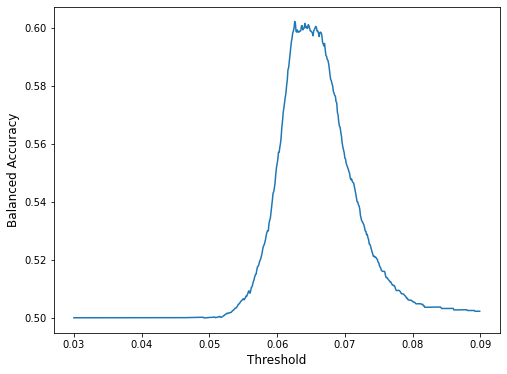

2672/2672 [==============================] - 3s 1ms/step
0.06248326842708453
ROC is  0.6416195980163871
0.5925507251023345
0.0035999373923931758
0.6330275229357798
[[47077 38196]
 [   80   138]]
Total misclassification costs are  110250.01000000001


110250.01000000001

In [186]:
reconstructions = autoencoder.predict(X_validate_transformed)
mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
print(np.mean(mse))
if mode == 'mse':
     error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_validate})
#else:
#    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_validate})
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

threshold = [] 
accuracy = [] 
precisions = []
recalls = []
ROCs = []
cm = []
start_time = time.time()
for p in np.arange(start=0.03, stop=0.09, step=0.0001):       
    threshold.append(p) 
    #y_prob = np.array(list(map(predict_prob, autoencoder.predict(X_validate_transformed))))
    y_pred = (mse >= p).astype(int) 
    acc = balanced_accuracy_score(y_validate, y_pred)
    prec = precision_score(y_validate,y_pred)
    recall = recall_score(y_validate,y_pred)
    accuracy.append(acc)
    precisions.append(prec)
    recalls.append(recall)
    C_M = confusion_matrix(y_validate, y_pred)
    cm.append(C_M)
    
print("--- %s seconds ---" % (time.time() - start_time))
ix = argmax(accuracy)    
th = threshold[ix]
print('optimal threshold = {} with accuracy = {}'.format(th, accuracy[ix]))

plt.figure(figsize=(8,6))
plt.plot(threshold, accuracy)
plt.xlabel('Threshold',fontsize=12 )
plt.ylabel('Balanced Accuracy', fontsize=12)
plt.show()       

# #TEST SET Performance 
reconstructions = autoencoder.predict(X_test_transformed)
mae = np.mean(np.absolute(X_test_transformed - reconstructions), axis=1)
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
print(np.mean(mse))
if mode == 'mse':
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
#else:
#    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_validate})
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

y_pred = (mse >= th).astype(int) 
print(balanced_accuracy_score(y_test, y_pred))
print(precision_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

cost_test_set(X_test, y_test, y_pred)

Results on test set with found validation set threshold
2672/2672 [==============================] - 3s 1ms/step
Accuracy is  0.9974500239791323
Balanced Accuracy is  0.5
[[85273     0]
 [  218     0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85273
           1       0.00      0.00      0.00       218

    accuracy                           1.00     85491
   macro avg       0.50      0.50      0.50     85491
weighted avg       0.99      1.00      1.00     85491

  99/2672 [>.............................] - ETA: 2s

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


2672/2672 [==============================] - 3s 1ms/step
ROC is  0.6223079043378972
2672/2672 [==============================] - 3s 1ms/step


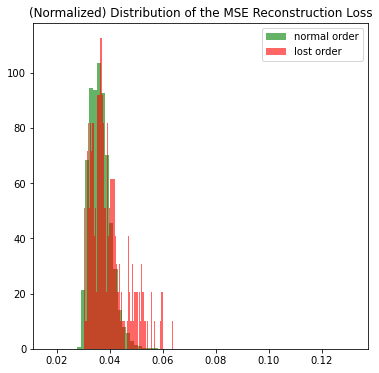

In [195]:
#See test results with founded threshold
print('Results on test set with found validation set threshold')
y_pred_ = autoencoder.predict(X_test_transformed)[:,1]
y_pred = (y_pred_ >= th).astype(int)
print('Accuracy is ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy is ', balanced_accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
CR = classification_report(y_test, y_pred)
print(cm)
print(CR)

reconstructions = autoencoder.predict(X_test_transformed)
mae = np.mean(np.absolute(X_test_transformed - reconstructions), axis=1)
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
if mode == 'mse':
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_test})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))
         
#Make plot of reconstruction errors on test set with set threshold 
reconstructions = autoencoder.predict(X_test_transformed)
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
clean_mse = mse[y_test== 0]
fraud_mse = mse[y_test== 1]                         
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(clean_mse, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud_mse, bins=75, density=True, label="lost order", alpha=.6, color="red")            
plt.title("(Normalized) Distribution of the MSE Reconstruction Loss")
plt.legend()
plt.show()                                                  

### 3.3.6 Latent representation plot

In [ ]:
encoder = tf.keras.models.Sequential(autoencoder.layers[:4])
encoder.summary()

fraud = X_test_transformed[y_test==1]
clean = X_test_transformed[y_test==0][:len(fraud) * 50]

# combining arrays & building labels
features = np.append(fraud, clean, axis=0)
labels = np.append(np.ones(len(fraud)),
                   np.zeros(len(clean)))

# getting latent space representation
latent_representation = encoder.predict(features)
print(f'Clean transactions downsampled from {len(X_test_transformed[y_test==0]):,} to {len(clean):,}.')
print('Shape of latent representation:', latent_representation.shape)

X = latent_representation[:,0]
y = latent_representation[:,1]

# plotting
plt.subplots(figsize=(12, 12))
plt.scatter(X[labels==0], y[labels==0], s=3, c='g', alpha=0.5, label='Normal orders')
plt.scatter(X[labels==1], y[labels==1], s=10, c='r', alpha=1, label='Lost orders')

# labeling
plt.legend(loc='best', fontsize = 12)
plt.xlabel('dimension 1', fontsize=12)
plt.ylabel('dimension 2', fontsize=12)
#plt.title('Latent Space Representation')

# saving & displaying
plt.savefig('latent_representation_2d');
plt.show()

### 3.3.7 Do Hyperparameter optimization

In [ ]:
optimizers = ['Adam', 'RMSprop']
loss = ['mse', 'binary_crossentropy']
activation_1 = ['sigmoid', 'softmax']
activation_2 = ['sigmoid', 'softmax', 'elu', 'relu']
batch_size = [500, 2000]
hidden_layers = [1, 3, 5]
nodes_start = [40, 20, 16, 8, 4]
dropout_rate = [0, 0.1, 0.3, 0.5]
places_dropout = [1, 3]
amount_of_features = [10, 15, 20, 25, 35, 50, 75, 100, 150]

In [ ]:
all_combs = list(itertools.product(optimizers, loss, activation_1, activation_2, batch_size, 
                                   hidden_layers, nodes_start, dropout_rate, places_dropout, amount_of_features))
all_combs = random.sample(all_combs, 100)

In [ ]:
start_time = time.time()
ROC_AUC, Balanced_Accuracy, CM, precision, recall, ix1, ix2 = do_hyperparameter_optimization_ae(all_combs)
print(ROC_AUC[ix1], ROC_AUC[ix2])
print(CM[ix1], CM[ix2])
print(Balanced_Accuracy[ix1], Balanced_Accuracy[ix2])
print("--- %s seconds ---" % (time.time() - start_time))

## 3.4 Variational Autoencoder

### 3.4.1 Create Variational Autoencoder

In [197]:
latent_dim = 4
activation_1 = 'sigmoid'
activation_2 = 'elu'
input_dim = X_train_transformed.shape[1]
BATCH_SIZE = 2000
EPOCHS = 100

#Encoder 
encoder_inputs = tf.keras.Input(shape = input_dim)
x = tf.keras.layers.Dense(input_dim, activation=activation_1, input_shape=(input_dim, ))(encoder_inputs) 
x = tf.keras.layers.Dense(8, activation=activation_2)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(4, activation=activation_2)(x)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(encoder_inputs, z, name='encoder')
dot_img_file = '/tmp/VAE_encoder.png'
tf.keras.utils.plot_model(encoder, to_file=dot_img_file, show_shapes=True)
print(encoder.summary())

#Decoder
latent_inputs = tf.keras.Input(shape = (latent_dim, ))
x = tf.keras.layers.Dense(8, activation=activation_2)(latent_inputs)
decoder_output = tf.keras.layers.Dense(input_dim, activation=activation_1)(x)
decoder = tf.keras.Model(latent_inputs, decoder_output , name = 'decoder')
dot_img_file = '/tmp/VAE_decoder.png'
tf.keras.utils.plot_model(decoder, to_file=dot_img_file, show_shapes=True)
print(decoder.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 dense_17 (Dense)               (None, 25)           650         ['input_3[0][0]']                
                                                                                                  
 dense_18 (Dense)               (None, 8)            208         ['dense_17[0][0]']               
                                                                                                  
 dropout_3 (Dropout)         

In [198]:
vae_input = tf.keras.layers.Input(shape=input_dim, name='VAE_input')
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tf.keras.models.Model(vae_input, vae_decoder_output, name='VAE')
dot_img_file = '/tmp/VAE.png'
tf.keras.utils.plot_model(vae, to_file=dot_img_file, show_shapes=True)
print(vae.summary())
vae.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_func(z_mean, z_log_var), metrics=["mse", 'AUC'])

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 25)]              0         
                                                                 
 encoder (Functional)        (None, 4)                 934       
                                                                 
 decoder (Functional)        (None, 25)                265       
                                                                 
Total params: 1,199
Trainable params: 1,199
Non-trainable params: 0
_________________________________________________________________
None


### 3.4.2 Train VAE

Epoch 1/100
(None, 25)
(None, 25)
(None, 25)
(None, 25)
302/307 [============================>.] - ETA: 0s - loss: 55.6091 - mse: 0.0543 - auc: 0.7234(None, 25)
(None, 25)
307/307 [==============================] - 3s 8ms/step - loss: 54.7938 - mse: 0.0535 - auc: 0.7244 - val_loss: 3.0692 - val_mse: 0.0022 - val_auc: 0.8142
Epoch 2/100
307/307 [==============================] - 2s 7ms/step - loss: 4.0824 - mse: 0.0033 - auc: 0.8148 - val_loss: 2.7839 - val_mse: 0.0020 - val_auc: 0.8240
Epoch 3/100
307/307 [==============================] - 2s 7ms/step - loss: 3.2534 - mse: 0.0024 - auc: 0.8205 - val_loss: 2.7559 - val_mse: 0.0019 - val_auc: 0.8242
Epoch 4/100
307/307 [==============================] - 2s 7ms/step - loss: 3.0488 - mse: 0.0022 - auc: 0.8219 - val_loss: 2.7505 - val_mse: 0.0019 - val_auc: 0.8242
Epoch 5/100
307/307 [==============================] - 2s 7ms/step - loss: 2.9369 - mse: 0.0021 - auc: 0.8225 - val_loss: 2.7492 - val_mse: 0.0019 - val_auc: 0.8242
Epoch 6/100
30

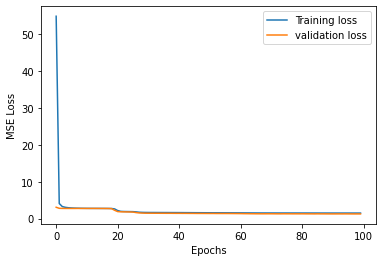

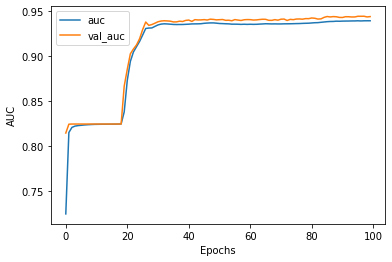

In [199]:
X_train_train_transformed, X_train_validate_transformed = train_test_split(X_train_transformed, 
                                                                        train_size = 0.9, random_state=random_state)

history = vae.fit(
    X_train_train_transformed, X_train_train_transformed,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_train_validate_transformed, X_train_validate_transformed)
)

plot_metrics(history)

### 3.4.3 See results VAE

2726/2726 [==============================] - 4s 1ms/step


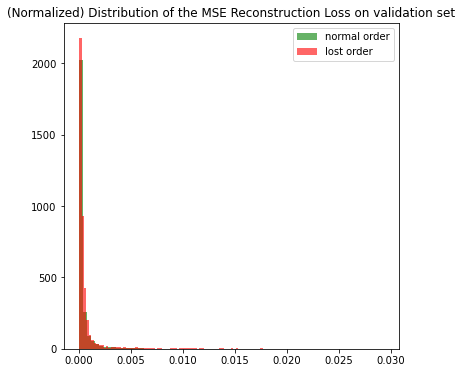

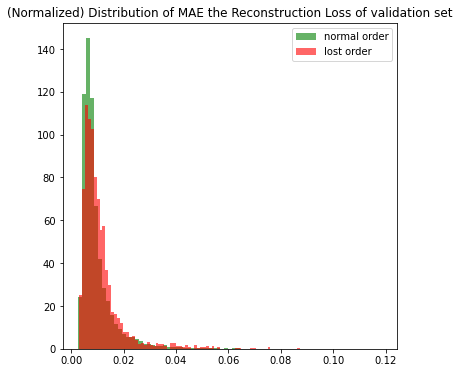

In [200]:
# Pass the transformed validation set through the autoencoder to get the reconstructed result
reconstructions = vae.predict(X_validate_transformed)

# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)

clean_mse = mse[y_validate== 0]
fraud_mse = mse[y_validate== 1]
clean_mae = mae[y_validate== 0]
fraud_mae = mae[y_validate== 1]

#Make plot of reconstruction errors 
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean_mse, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud_mse, bins=75, density=True, label="lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the MSE Reconstruction Loss on validation set")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean_mae, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud_mae, bins=75, density=True, label="lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of MAE the Reconstruction Loss of validation set")
plt.legend()
plt.show()

In [201]:
z_scores = mad_score(mae)
outliers = z_scores > THRESHOLD
print(f"MAE Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

#MSE
z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD
print(f"MSE Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

MAE Detected 27,071 outliers in a total of 87,228 transactions [31.03%].
MSE Detected 25,198 outliers in a total of 87,228 transactions [28.89%].


### 3.4.4 Results with Threshold via Z-scores on validation set 

optimal threshold for MAE = 1.2100000000000006 with accuracy = 0.5529992943547807
optimal threshold for MSE = 1.0900000000000005 with accuracy = 0.5644188326694167
Results on the validation set, with chosen z-score threshold =  1.0900000000000005
ROC is  0.5807539415312117
The classifications using the MAD method on validation set with threshold=1.0 are as follows:
[[62908 22364]
 [ 1191   765]]

# % of transactions labeled as fraud that were correct (precision): 765/(22364+765) = 3.31%
# % of fraudulent transactions were caught succesfully (recall):    765/(1191+765) = 39.11%
Balanced accuracy =  0.5644188326694167
              precision    recall  f1-score   support

           0       0.98      0.74      0.84     85272
           1       0.03      0.39      0.06      1956

    accuracy                           0.73     87228
   macro avg       0.51      0.56      0.45     87228
weighted avg       0.96      0.73      0.82     87228



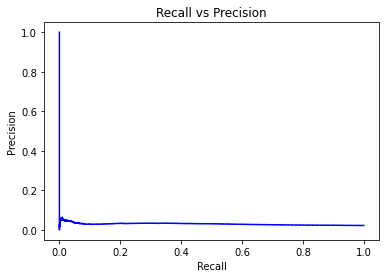

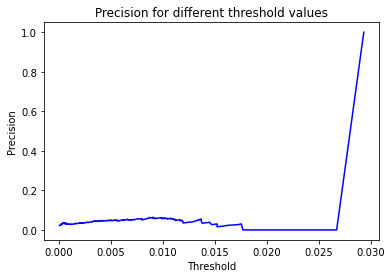

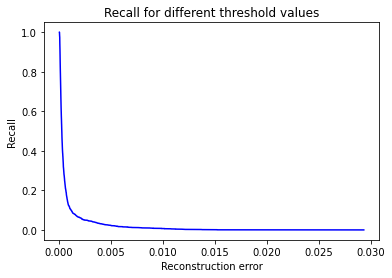

In [202]:
#Setting a supervised threshold via Z-scores on training set. 
threshold = [] 
accuracy_mae = []
accuracy_mse = []
for p in np.arange(start=0.5, stop=1.5, step=0.01):       
    z_scores_mae = mad_score(mae)
    z_scores_mse = mad_score(mse)
    outliers_mse = z_scores_mse > p 
    outliers_mae = z_scores_mae > p
    accuracy_mae.append(balanced_accuracy_score(y_validate, outliers_mae))
    accuracy_mse.append(balanced_accuracy_score(y_validate, outliers_mse))
    threshold.append(p) 
    
ix_1 = argmax(accuracy_mae)    
ix_2 = argmax(accuracy_mse)
th_1 = threshold[ix_1]
th_2 = threshold[ix_2]
print('optimal threshold for MAE = {} with accuracy = {}'.format(th_1, accuracy_mae[ix_1]))
print('optimal threshold for MSE = {} with accuracy = {}'.format(th_2, accuracy_mse[ix_2]))

if accuracy_mae[ix_1] > accuracy_mse[ix_2]:
    threshold = threshold[ix_1]
    z_scores = mad_score(mae)
    outliers = z_scores > threshold
    mode = 'mae'
else:
    threshold = threshold[ix_2]
    z_scores = mad_score(mse)
    outliers = z_scores > threshold
    mode = 'mse'

print('Results on the validation set, with chosen z-score threshold = ', threshold)

cm = confusion_matrix(y_validate, outliers)
BA = balanced_accuracy_score(y_validate, outliers)
CR = classification_report(y_validate, outliers)
if mode == 'mse': 
    error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_validate})
else: 
    error_df = pd.DataFrame({'reconstruction_error': mae, 'true_class': y_validate})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method on validation set with threshold={THRESHOLD} are as follows:
{cm}

# % of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
# % of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
print('Balanced accuracy = ', BA)
print(CR)

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

2672/2672 [==============================] - 4s 1ms/step


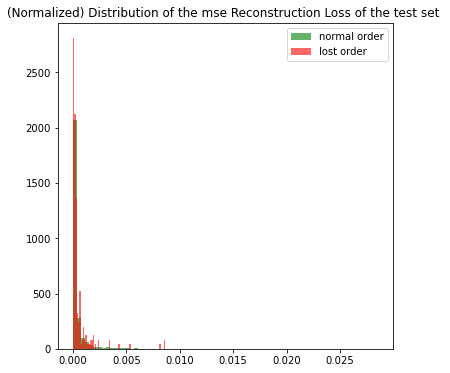

Results on the test set, with chosen z-score threshold =  1.0900000000000005
ROC is  0.5653603423951804
The classifications using the MAD method on validation set with threshold=1.0 are as follows:
[[62599 22674]
 [  141    77]]

# % of transactions labeled as fraud that were correct (precision): 77/(22674+77) = 0.34%
# % of fraudulent transactions were caught succesfully (recall):    77/(141+77) = 35.32%
Balanced accuracy =  0.5436560364084828
              precision    recall  f1-score   support

           0       1.00      0.73      0.85     85273
           1       0.00      0.35      0.01       218

    accuracy                           0.73     85491
   macro avg       0.50      0.54      0.43     85491
weighted avg       1.00      0.73      0.84     85491



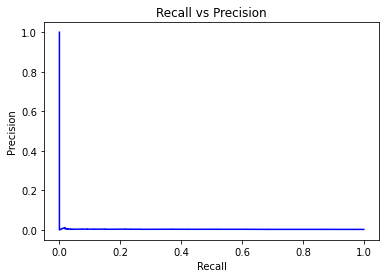

In [203]:
# Test set results
# Pass the transformed validation set through the autoencoder to get the reconstructed result
reconstructions = vae.predict(X_test_transformed)

# calculating the mean squared error reconstruction loss per row in the numpy array
if mode == 'mse':
    mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
    clean = mse[y_test==0]
    fraud = mse[y_test ==1]
    z_scores = mad_score(mse)
    outliers = z_scores > threshold
else: 
    mae = np.mean(np.absolute(X_test_transformed - reconstructions), axis=1)
    clean = mae[y_test==0]
    fraud = mae[y_test ==1]
    z_scores = mad_score(mae)
    outliers = z_scores > threshold
    
#Make plot of reconstruction errors 
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud, bins=75, density=True, label="lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the {} Reconstruction Loss of the test set ".format(mode))
plt.legend()
plt.show()

print('Results on the test set, with chosen z-score threshold = ', threshold)
cm = confusion_matrix(y_test, outliers)
BA = balanced_accuracy_score(y_test, outliers)
CR = classification_report(y_test, outliers)
if mode == 'mse': 
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_test})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method on validation set with threshold={THRESHOLD} are as follows:
{cm}

# % of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
# % of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
print('Balanced accuracy = ', BA)
print(CR)

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### 3.4.5 Results with threshold via balanced accuracy optimization on validation set 

2726/2726 [==============================] - 4s 1ms/step


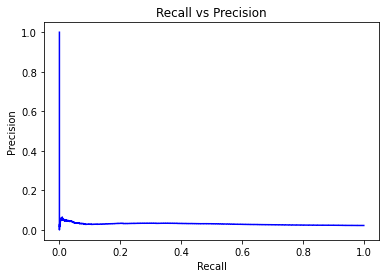

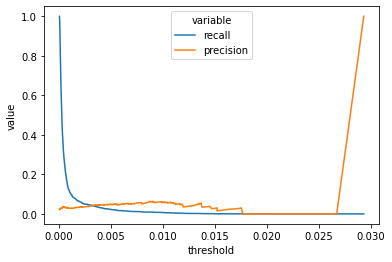

2726/2726 [==============================] - 4s 1ms/step
optimal threshold = 0.0005 with accuracy = 0.5438508357521539


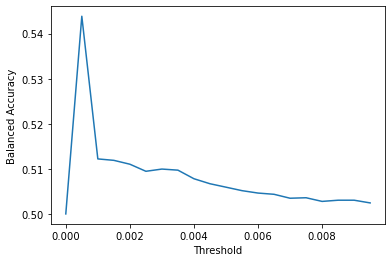

Results on validation set with found validation set threshold
2726/2726 [==============================] - 4s 1ms/step
Accuracy is  0.8142798184069335
Balanced Accuracy is  0.5438566993416089
ROC is  0.5807391626477696
[[70518 14754]
 [ 1446   510]]


In [204]:
#precision recall curve on validation set 
reconstructions = vae.predict(X_validate_transformed)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_validate})

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

#plot 1
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#plot 2
val_prt = pd.DataFrame({
    "threshold": th,
    "recall": recall[1:],
    "precision": precision[1:]})
val_prt_melted = pd.melt(val_prt, id_vars = ["threshold"], value_vars = ["recall", "precision"])
sns.lineplot(x = "threshold", y = "value", hue = "variable", data = val_prt_melted)
plt.show()

#Setting a supervised threshold via ROC_AUC optimization on validation set
reconstructions = vae.predict(X_validate_transformed)
mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
if mode == 'mse':
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_validate})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_validate})

threshold = [] 
accuracy = [] 
for p in np.arange(start=0.00, stop=0.01, step=0.0005):       
    threshold.append(p) 
    #y_prob = np.array(list(map(predict_prob, autoencoder.predict(X_validate_transformed))))
    y_pred_ = vae.predict(X_validate_transformed)[:,1]
    y_pred = (mse >= p).astype(int) 
    acc = balanced_accuracy_score(y_validate, y_pred)
    accuracy.append(acc)

ix = argmax(accuracy)    
th = threshold[ix]
print('optimal threshold = {} with accuracy = {}'.format(th, accuracy[ix]))

#See results from validation set
plt.plot(threshold, accuracy)
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.show()    

print('Results on validation set with found validation set threshold')
reconstructions = vae.predict(X_validate_transformed)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
y_pred = (mse >= th).astype(int)
print('Accuracy is ', accuracy_score(y_validate, y_pred))
print('Balanced Accuracy is ', balanced_accuracy_score(y_validate, y_pred))
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))
print(confusion_matrix(y_validate, y_pred))


Results on validation set with found validation set threshold
2726/2726 [==============================] - 4s 1ms/step
Accuracy is  0.8142912826156739
Precicion is  0.03341413876695276
Recall is  0.2607361963190184
Balanced Accuracy is  0.5438625629310637
ROC is  0.5807391626477696

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     85272
           1       0.03      0.26      0.06      1956

    accuracy                           0.81     87228
   macro avg       0.51      0.54      0.48     87228
weighted avg       0.96      0.81      0.88     87228

[[70519 14753]
 [ 1446   510]]
Results on test set with found validation set threshold
2672/2672 [==============================] - 4s 1ms/step
Accuracy is  0.8271396989156753
Balanced Accuracy is  0.5313005762280821
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     85273
           1       0.00      0.23      0.01       218

    accu

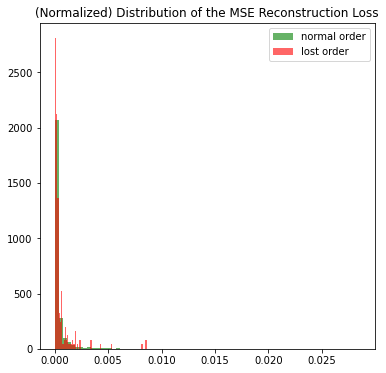

Total misclassification costs are  105731.61


105731.61

In [205]:
#See validation set results with founded threshold
print('Results on validation set with found validation set threshold')
reconstructions = vae.predict(X_validate_transformed)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
y_pred = (mse >= th).astype(int)
print('Accuracy is ', accuracy_score(y_validate, y_pred))
print('Precicion is ', precision_score(y_validate, y_pred))
print('Recall is ', recall_score (y_validate, y_pred))
print('Balanced Accuracy is ', balanced_accuracy_score(y_validate, y_pred))
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))
print()
CR = classification_report(y_validate, y_pred)
print(CR)
print(confusion_matrix(y_validate, y_pred))

#See test results with founded threshold
print('Results on test set with found validation set threshold')

reconstructions = vae.predict(X_test_transformed)
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
y_pred = (mse >= th).astype(int)
print('Accuracy is ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy is ', balanced_accuracy_score(y_test, y_pred))
CR = classification_report(y_test, y_pred)
print(CR)
print(confusion_matrix(y_test, y_pred))

reconstructions = vae.predict(X_test_transformed)
mae = np.mean(np.absolute(X_test_transformed - reconstructions), axis=1)
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
if mode == 'mse':
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_test})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))
         
#Make plot of reconstruction errors on test set with set threshold 
reconstructions = vae.predict(X_test_transformed)
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
clean_mse = mse[y_test== 0]
fraud_mse = mse[y_test== 1]                         
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(clean_mse, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud_mse, bins=75, density=True, label="lost order", alpha=.6, color="red")            
plt.title("(Normalized) Distribution of the MSE Reconstruction Loss")
plt.legend()
plt.show()   


cost_test_set(X_test, y_test, y_pred)

### 3.4.6 Do hyperparameter optimization

In [ ]:
optimizers = ['Adam']
loss = ['mse']
activation_1 = ['sigmoid', 'softmax']
activation_2 = ['sigmoid', 'softmax', 'elu', 'relu']
batch_size = [500, 2000]
hidden_layers = [1, 3, 5]
nodes_start = [40, 20, 16, 8, 4]
dropout_rate = [0, 0.1, 0.3, 0.5]
places_dropout = [1, 3]
amount_of_features = [10, 15, 20, 25, 35, 50, 75, 100, 150]
latent_dim = [1,2,3,4,5,10]

In [ ]:
all_combs = list(itertools.product(optimizers, loss, activation_1, activation_2, batch_size, 
                                   hidden_layers, nodes_start, dropout_rate, places_dropout, amount_of_features, latent_dim))
all_combs = random.sample(all_combs, 100)

In [ ]:
ROC_AUC, Balanced_Accuracy, CM, precision, recall, ix1, ix2 = do_hyperparameter_optimization_vae(all_combs)
print(ROC_AUC[ix1], ROC_AUC[ix2])
print(CM[ix1], CM[ix2])
print(Balanced_Accuracy[ix1], Balanced_Accuracy[ix2])

## 3.5 Denoising Autoencoder

### 3.5.1 Create Noise in input data

In [12]:
mu=0.0
std=0.2

In [13]:
X_train_train_transformed, X_train_validate_transformed = train_test_split(X_train_transformed, 
                                                                        train_size = 0.9, random_state=random_state)

X_train_train_transformed_n = gaussian_noise(X_train_train_transformed, 0, std)
X_train_validate_transformed_n = gaussian_noise(X_train_validate_transformed, 0, std)
X_validate_transformed_n = gaussian_noise(X_validate_transformed, 0, std)
X_test_transformed_n = gaussian_noise(X_test_transformed, 0, std)
input_dim = X_train_transformed.shape[1]

### 3.5.2 Create DAE

In [14]:
dae = create_dae()

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 208       
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 dense_8 (Dense)             (None, 2)                 10        
                                                                 
 dense_9 (Dense)        

### 3.5.3 Train DAE

Epoch 1/20
614/614 [==============================] - 5s 7ms/step - loss: 0.0668 - mse: 0.0668 - auc: 0.0000e+00 - accuracy: 0.3109 - val_loss: 0.0637 - val_mse: 0.0637 - val_auc: 0.0000e+00 - val_accuracy: 0.3540
Epoch 2/20
614/614 [==============================] - 4s 6ms/step - loss: 0.0636 - mse: 0.0636 - auc: 0.0000e+00 - accuracy: 0.3577 - val_loss: 0.0634 - val_mse: 0.0634 - val_auc: 0.0000e+00 - val_accuracy: 0.3540
Epoch 3/20
614/614 [==============================] - 4s 6ms/step - loss: 0.0630 - mse: 0.0630 - auc: 0.0000e+00 - accuracy: 0.3577 - val_loss: 0.0624 - val_mse: 0.0624 - val_auc: 0.0000e+00 - val_accuracy: 0.3540
Epoch 4/20
614/614 [==============================] - 4s 6ms/step - loss: 0.0619 - mse: 0.0619 - auc: 0.0000e+00 - accuracy: 0.3643 - val_loss: 0.0617 - val_mse: 0.0617 - val_auc: 0.0000e+00 - val_accuracy: 0.3766
Epoch 5/20
614/614 [==============================] - 4s 6ms/step - loss: 0.0617 - mse: 0.0617 - auc: 0.0000e+00 - accuracy: 0.3787 - val_loss: 

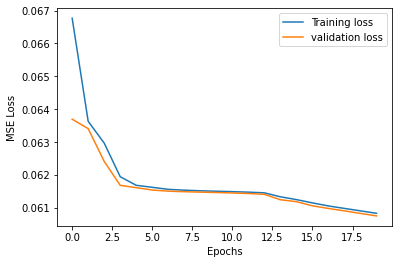

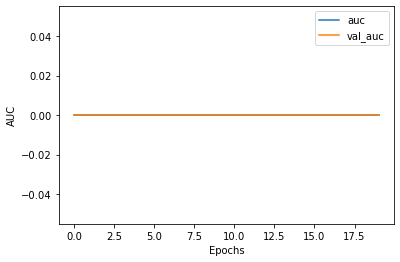

In [15]:
BATCH_SIZE =1000
EPOCHS = 20
history = dae.fit(
    X_train_train_transformed_n, X_train_train_transformed_n,
    shuffle=True,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=cb,
    validation_data=(X_train_validate_transformed_n, X_train_validate_transformed_n))

plot_metrics(history)

### 3.5.4 Results DAE

2726/2726 [==============================] - 4s 1ms/step
MAE Detected 29,729 outliers in a total of 87,228 transactions [34.08%].
MSE Detected 25,338 outliers in a total of 87,228 transactions [29.05%].


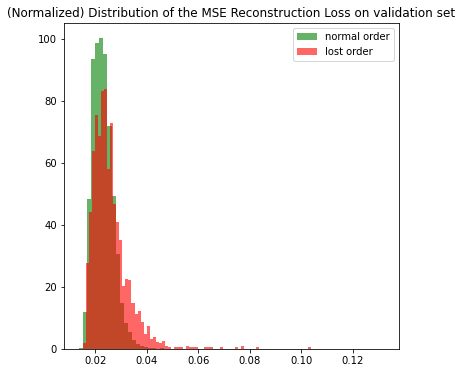

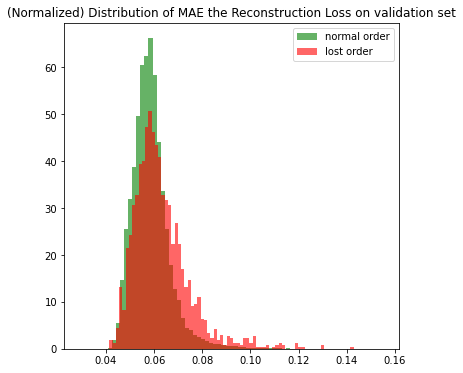

In [206]:
# Pass the transformed test set through the autoencoder to get the reconstructed result
reconstructions = dae.predict(X_validate_transformed)

# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)

clean_mse = mse[y_validate== 0]
fraud_mse = mse[y_validate== 1]
clean_mae = mae[y_validate== 0]
fraud_mae = mae[y_validate== 1]

THRESHOLD = 1

#MAE
z_scores = mad_score(mae)
outliers = z_scores > THRESHOLD
print(f"MAE Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

#MSE
z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD
print(f"MSE Detected {np.sum(outliers):,} outliers in a total of {np.size(z_scores):,} transactions [{np.sum(outliers)/np.size(z_scores):.2%}].")

#plot reconstruction loss validation set
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean_mse, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud_mse, bins=75, density=True, label="lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the MSE Reconstruction Loss on validation set")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean_mae, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud_mae, bins=75, density=True, label="lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of MAE the Reconstruction Loss on validation set")
plt.legend()
plt.show()

### 3.5.5 Results Threshold via Z-scores on validation set 

optimal threshold for MAE = 1.1300000000000006 with accuracy = 0.577072242875487
optimal threshold for MSE = 1.3200000000000007 with accuracy = 0.5828947152583404
Results on the validation set, with chosen z-score threshold =  1.3200000000000007
ROC is  0.6140041270076979
The classifications using the MAD method on validation set with threshold=1.3200000000000007 are as follows:
[[72729 12543]
 [ 1344   612]]
# % of transactions labeled as fraud that were correct (precision): 612/(12543+612) = 4.65%
# % of fraudulent transactions were caught succesfully (recall):    612/(1344+612) = 31.29%
Balanced accuracy =  0.5828947152583404
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     85272
           1       0.05      0.31      0.08      1956

    accuracy                           0.84     87228
   macro avg       0.51      0.58      0.50     87228
weighted avg       0.96      0.84      0.89     87228



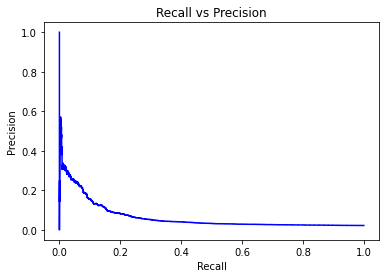

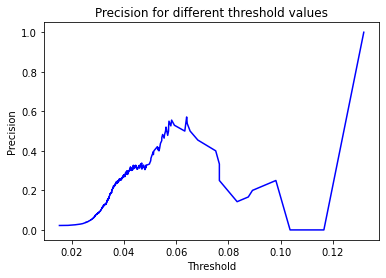

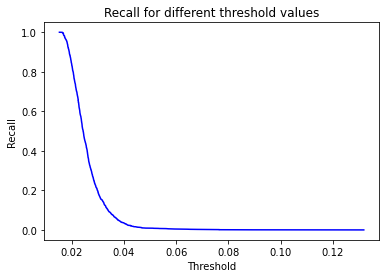

In [207]:
#Setting a supervised threshold via Z-scores on training set. 
threshold = [] 
accuracy_mae = []
accuracy_mse = []
for p in np.arange(start=0.5, stop=1.5, step=0.01):       
    z_scores_mae = mad_score(mae)
    z_scores_mse = mad_score(mse)
    outliers_mse = z_scores_mse > p 
    outliers_mae = z_scores_mae > p
    accuracy_mae.append(balanced_accuracy_score(y_validate, outliers_mae))
    accuracy_mse.append(balanced_accuracy_score(y_validate, outliers_mse))
    threshold.append(p) 
    
ix_1 = argmax(accuracy_mae)    
ix_2 = argmax(accuracy_mse)
th_1 = threshold[ix_1]
th_2 = threshold[ix_2]
print('optimal threshold for MAE = {} with accuracy = {}'.format(th_1, accuracy_mae[ix_1]))
print('optimal threshold for MSE = {} with accuracy = {}'.format(th_2, accuracy_mse[ix_2]))

if accuracy_mae[ix_1] > accuracy_mse[ix_2]:
    threshold = threshold[ix_1]
    z_scores = mad_score(mae)
    outliers = z_scores > threshold
    mode = 'mae'
else:
    threshold = threshold[ix_2]
    z_scores = mad_score(mse)
    outliers = z_scores > threshold
    mode = 'mse'

#print results 
print('Results on the validation set, with chosen z-score threshold = ', threshold)
cm = confusion_matrix(y_validate, outliers)
BA = balanced_accuracy_score(y_validate, outliers)
CR = classification_report(y_validate, outliers)
if mode == 'mse': 
    error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_validate})
else: 
    error_df = pd.DataFrame({'reconstruction_error': mae, 'true_class': y_validate})
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method on validation set with threshold={threshold} are as follows:
{cm}
# % of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
# % of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
print('Balanced accuracy = ', BA)
print(CR)

#Some plots
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Recall')
plt.show()

2672/2672 [==============================] - 3s 1ms/step


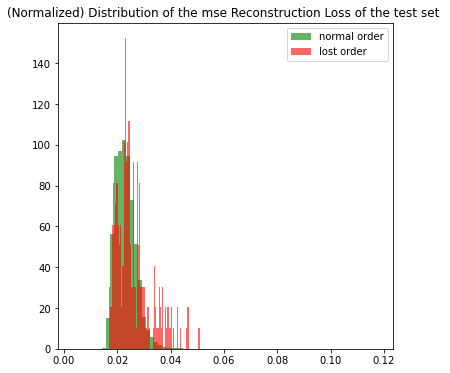

Results on the test set, with chosen z-score threshold =  1.3200000000000007
ROC is  0.6265611085905742
The classifications using the MAD method on validation set with threshold=1.3200000000000007 are as follows:
[[72314 12959]
 [  148    70]]

# % of transactions labeled as fraud that were correct (precision): 70/(12959+70) = 0.54%
# % of fraudulent transactions were caught succesfully (recall):    70/(148+70) = 32.11%
Balanced accuracy =  0.5845650940632445
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     85273
           1       0.01      0.32      0.01       218

    accuracy                           0.85     85491
   macro avg       0.50      0.58      0.46     85491
weighted avg       1.00      0.85      0.91     85491



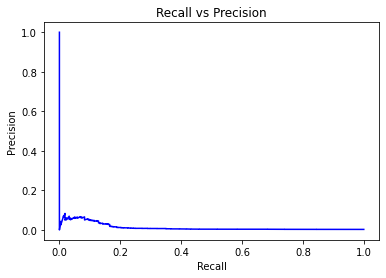

In [208]:
# Test set results
# Pass the transformed validation set through the autoencoder to get the reconstructed result
reconstructions = dae.predict(X_test_transformed)

# calculating the mean squared error reconstruction loss per row in the numpy array
if mode == 'mse':
    mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
    clean = mse[y_test==0]
    fraud = mse[y_test ==1]
    z_scores = mad_score(mse)
    outliers = z_scores > threshold
else: 
    mae = np.mean(np.absolute(X_test_transformed - reconstructions), axis=1)
    clean = mae[y_test==0]
    fraud = mae[y_test ==1]
    z_scores = mad_score(mae)
    outliers = z_scores > threshold
    
#Make plot of reconstruction errors 
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud, bins=75, density=True, label="lost order", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the {} Reconstruction Loss of the test set ".format(mode))
plt.legend()
plt.show()

print('Results on the test set, with chosen z-score threshold = ', threshold)
cm = confusion_matrix(y_test, outliers)
BA = balanced_accuracy_score(y_test, outliers)
CR = classification_report(y_test, outliers)
if mode == 'mse': 
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_test})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()

print(f"""The classifications using the MAD method on validation set with threshold={threshold} are as follows:
{cm}

# % of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}
# % of fraudulent transactions were caught succesfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}""")
print('Balanced accuracy = ', BA)
print(CR)

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### 3.5.5 Results with threshold via balanced accuracy optimization on validation set 

2726/2726 [==============================] - 4s 1ms/step


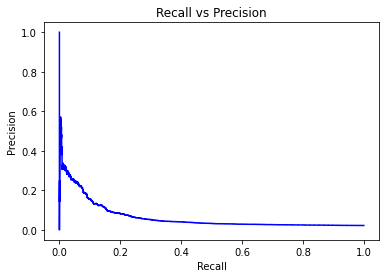

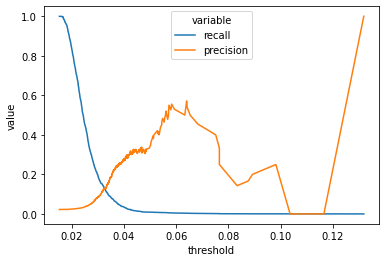

2726/2726 [==============================] - 3s 1ms/step
optimal threshold = 0.025 with accuracy = 0.5856404579326667


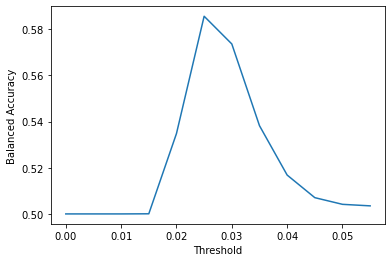

In [209]:
#precision recall curve on validation set 
reconstructions = dae.predict(X_validate_transformed)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_validate})

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)

#plot 1
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

#plot 2
val_prt = pd.DataFrame({
    "threshold": th,
    "recall": recall[1:],
    "precision": precision[1:]})
val_prt_melted = pd.melt(val_prt, id_vars = ["threshold"], value_vars = ["recall", "precision"])
sns.lineplot(x = "threshold", y = "value", hue = "variable", data = val_prt_melted)
plt.show()

#Setting a supervised threshold via ROC_AUC optimization on validation set, then see results on test set 
reconstructions = dae.predict(X_validate_transformed)
mae = np.mean(np.absolute(X_validate_transformed - reconstructions), axis=1)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
if mode == 'mse':
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_validate})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_validate})

threshold = [] 
accuracy = [] 
for p in np.arange(start=0.00, stop=0.06, step=0.005):       
    threshold.append(p) 
    #y_prob = np.array(list(map(predict_prob, autoencoder.predict(X_validate_transformed))))
    y_pred_ = dae.predict(X_validate_transformed)[:,1]
    y_pred = (mse >= p).astype(int) 
    acc = balanced_accuracy_score(y_validate, y_pred)
    accuracy.append(acc)

ix = argmax(accuracy)    
th = threshold[ix]
print('optimal threshold = {} with accuracy = {}'.format(th, accuracy[ix]))

plt.plot(threshold, accuracy)
plt.xlabel('Threshold')
plt.ylabel('Balanced Accuracy')
plt.show()          

Results on validation set with found validation set threshold
2726/2726 [==============================] - 3s 1ms/step
Accuracy is  0.7138304214243133
Precicion is  0.03564508315840465
Recall is  0.4514314928425358
Balanced Accuracy is  0.5856404579326667
ROC is  0.6140041270076979

              precision    recall  f1-score   support

           0       0.98      0.72      0.83     85272
           1       0.04      0.45      0.07      1956

    accuracy                           0.71     87228
   macro avg       0.51      0.59      0.45     87228
weighted avg       0.96      0.71      0.81     87228

[[61383 23889]
 [ 1073   883]]
Results on test set with found validation set threshold
2672/2672 [==============================] - 4s 1ms/step
Accuracy is  0.7187774151665087
Balanced Accuracy is  0.5822157857381317
              precision    recall  f1-score   support

           0       1.00      0.72      0.84     85273
           1       0.00      0.44      0.01       218

    accu

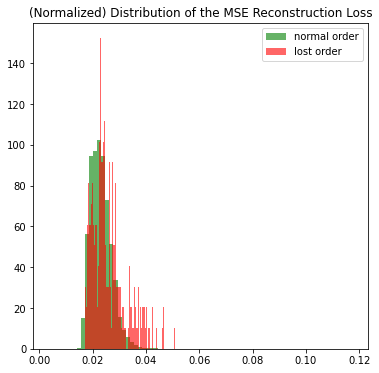

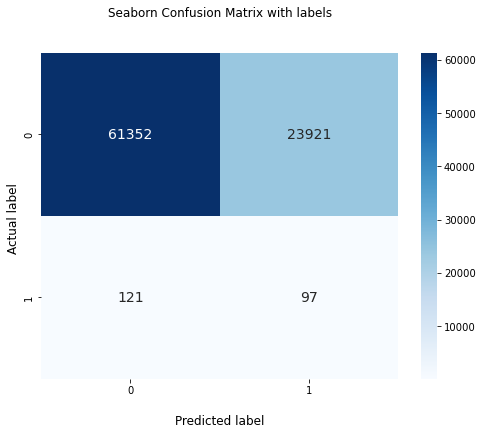

Total misclassification costs are  96850.52000000002


96850.52000000002

In [210]:
#See validation set results with founded threshold
print('Results on validation set with found validation set threshold')
reconstructions = dae.predict(X_validate_transformed)
mse = np.mean(np.power(X_validate_transformed - reconstructions, 2), axis=1)
y_pred = (mse >= th).astype(int)
print('Accuracy is ', accuracy_score(y_validate, y_pred))
print('Precicion is ', precision_score(y_validate, y_pred))
print('Recall is ', recall_score (y_validate, y_pred))
print('Balanced Accuracy is ', balanced_accuracy_score(y_validate, y_pred))
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))
print()
CR = classification_report(y_validate, y_pred)
print(CR)
print(confusion_matrix(y_validate, y_pred))

#See test results with founded threshold
print('Results on test set with found validation set threshold')

reconstructions = dae.predict(X_test_transformed)
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
y_pred = (mse >= th).astype(int)
print('Accuracy is ', accuracy_score(y_test, y_pred))
print('Balanced Accuracy is ', balanced_accuracy_score(y_test, y_pred))
CR = classification_report(y_test, y_pred)
print(CR)
print(confusion_matrix(y_test, y_pred))

reconstructions = dae.predict(X_test_transformed)
mae = np.mean(np.absolute(X_test_transformed - reconstructions), axis=1)
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
if mode == 'mse':
    error_df = pd.DataFrame({'reconstruction_error': mse,'true_class': y_test})
else:
    error_df = pd.DataFrame({'reconstruction_error': mae,'true_class': y_test})

fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
print('ROC is ', auc(fpr, tpr))
         
#Make plot of reconstruction errors on test set with set threshold 
reconstructions = dae.predict(X_test_transformed)
# calculating the mean squared error reconstruction loss per row in the numpy array
mse = np.mean(np.power(X_test_transformed - reconstructions, 2), axis=1)
clean_mse = mse[y_test== 0]
fraud_mse = mse[y_test== 1]                         
fig, ax = plt.subplots(figsize=(6,6))
ax.hist(clean_mse, bins=75, density=True, label="normal order", alpha=.6, color="green")
ax.hist(fraud_mse, bins=75, density=True, label="lost order", alpha=.6, color="red")            
plt.title("(Normalized) Distribution of the MSE Reconstruction Loss")
plt.legend()
plt.show()                                                  

make_confusion_matrix(y_test, y_pred)

cost_test_set(X_test, y_test, y_pred)

### 3.5.6 Do hyperparameter optimization

In [ ]:
#Additional parameters relative to regular AE is amount of noise added to 
optimizers = ['Adam']
loss = ['mse']
activation_1 = ['sigmoid', 'relu', 'elu']
activation_2 = ['sigmoid', 'relu', 'elu']
batch_size = [500, 1000]
dropout_rate = [0.1, 0.2, 0.5]
places_dropout = [1, 3]
amount_of_features = [15, 20, 25]

#parameters interesting for DAE
hidden_layers = [3,5]
nodes_start = [2, 4, 8, 16]
std_noise = [0.01, 0.02, 0.05, 0.1, 0.2]

all_combs = list(itertools.product(optimizers, loss, activation_1, activation_2, batch_size, 
                                   hidden_layers, nodes_start, dropout_rate, places_dropout, amount_of_features, std_noise))
all_combs = random.sample(all_combs, 2)

In [ ]:
ROC_AUC, Balanced_Accuracy, CM, precision, recall, ix1, ix2 = do_hyperparameter_optimization_dae(all_combs)
print(ROC_AUC[ix1], ROC_AUC[ix2])
print(CM[ix1], CM[ix2])
print(Balanced_Accuracy[ix1], Balanced_Accuracy[ix2])

# 4. Business Evaluation

In [211]:
#train best feasible model
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.1, random_state=1)
RU = RandomUnderSampler(sampling_strategy = 0.2)             
X_train_RU, y_train_RU = RU.fit_resample(X_train, y_train)

RF1 = RandomForestClassifier(criterion = 'entropy', max_depth = 10, max_features = 10, min_samples_split = 100, 
                            n_estimators = 200, class_weight = 'balanced', random_state=random_state)
model = RF1.fit(X_train_RU, y_train_RU)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


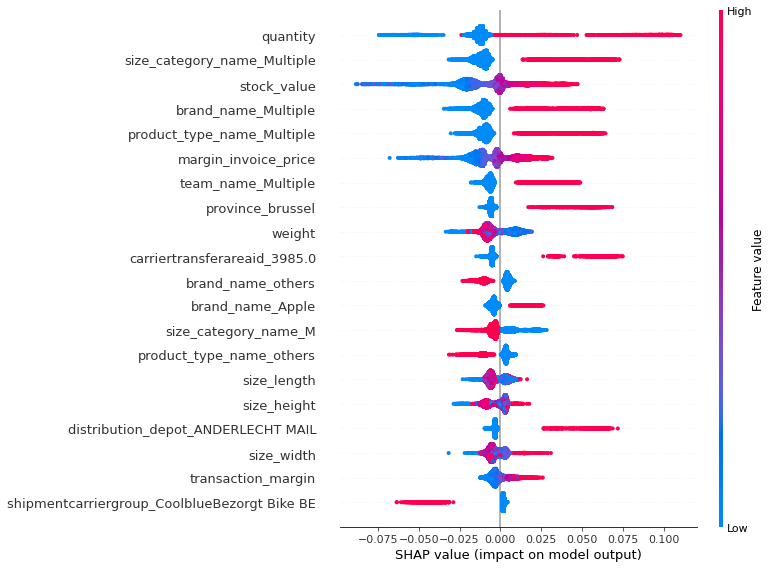

In [212]:
#Get SHAP values of 20 most important features
shap_values = shap.TreeExplainer(model).shap_values(X_train_RU)
shap.summary_plot(shap_values[1], X_train_RU, plot_type='dot', max_display = 20)
plt.show()
fig.savefig('shap_global.png', dpi=800, bbox_inches='tight')

In [ ]:
interesting_features = ['shipmentcarriergroup_PostNL BE', 'shipmentcarriergroup_Bpost', 
                      'is_b2b_customer_True']

for i in interesting_features:
    shap.dependence_plot(i, shap_values[0], X_train_RU)
    plt.show()

In [ ]:
#local interpretability 
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(model.predict(X_output),2)

df_test = pd.concat([X_output.reset_index(drop=True),y_test.reset_index(drop=True)], axis=1)
S = df_test.groupby('Is_lost_item').sample(n=200)
S

# # Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

explainer = shap.Explainer(model, S)
shap_values = explainer.shap_values(S)

for i in range(20):
    shap.force_plot(explainer.expected_value[0], shap_values[1][i], S.iloc[[i]], text_rotation=90, matplotlib=True)
    plt.show()

## 4.1 Validate performance by second best model

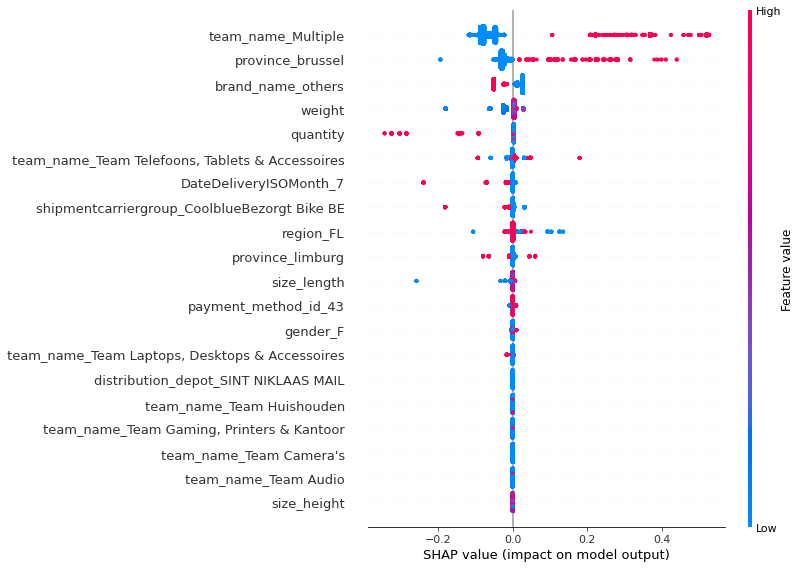

In [254]:
DT1 = DecisionTreeClassifier(random_state=2, class_weight='balanced', max_features=10, max_depth=4, min_samples_split=5)
model = DT1.fit(X_train_RU, y_train_RU)

shap_values = shap.TreeExplainer(model).shap_values(X_train_RU)
shap.summary_plot(shap_values[1], X_train_RU, plot_type='dot', max_display = 20)
plt.show()
fig.savefig('shap_global_dt.png', dpi=800, bbox_inches='tight')

In [ ]:
#Feature importances for UB-LR model
import math

#X_train_RU = X_train_RU.drop('DateDeliveryISOMonth_12', axis=1)
LR4 = LogisticRegression(penalty = 'l2' , solver = 'lbfgs', random_state=random_state, C=1)
LR4.fit(X_train_RU, y_train_RU)
#clf2 = BalancedBaggingClassifier(random_state=random_state, base_estimator=LR4).fit(X_train, y_train)

w0 = LR4.intercept_[0]
w = LR4.coef_[0]
feature_importance = pd.DataFrame(X_train_RU.columns, columns = ["feature"])
feature_importance["importance"] = pow(math.e, w)
feature_importance = feature_importance.sort_values(by = ["importance"], ascending=False)
print(feature_importance.describe())
feature_importance = feature_importance[:20]
feature_importance = feature_importance.reindex(index=feature_importance.index[::-1])

from sklearn.linear_model import LogisticRegression
fig, ax = plt.subplots(figsize=(15, 10))
feature_importance.plot.barh(x='feature', y='importance', ax=ax, fontsize=14)
plt.figure(figsize=(25,20), dpi=800)
plt.ylabel('Feature name')
plt.xlabel('Feature importance')
plt.show()

## 4.2 Make decision tree model

In [284]:
from sklearn import tree
import graphviz
import pydotplus

DT1 = DecisionTreeClassifier(random_state=2, class_weight='balanced', max_features=None, max_depth=3, min_samples_split=5)
model = DT1.fit(X_train_RU, y_train_RU)

# dot_data = tree.export_graphviz(model, out_file=None, filled=True, feature_names=X_train_RU.columns, class_names=True)
# graph = pydotplus.graph_from_dot_data(dot_data)
# graph = graphviz.Source(tree_vis, format="png") 
# graph
# plt.figure(figsize=(30, 30) # Resize figure
# plot_tree(classifier, filled=True)
# plt.show()

fig = plt.figure(figsize=(20,20), dpi=500)
_ = tree.plot_tree(model, feature_names = X_train.columns, class_names = True, proportion=True, fontsize=9)
fig.savefig("decistion_tree.png")

In [286]:
y_pred2 = model.predict(X_test)
y_pred_proba2 = model.predict_proba(X_test)
print(confusion_matrix(y_test, y_pred2))
print(balanced_accuracy_score(y_test, y_pred2))
print(recall_score(y_test, y_pred2))
print(precision_score(y_test, y_pred2))
print('LR costs are', calculate_cost(y_test, y_pred2))
fpr, tpr, thresh = roc_curve(y_test, y_pred_proba2[:, 1])
auc_ = roc_auc_score(y_test, y_pred_proba2[:, 1])
ax.plot(fpr, tpr,label="DT, auc="+str(round(auc_,3)))
cost_test_set(X_test, y_test, y_pred2)

[[70217 15056]
 [   99   118]]
0.6836082333774187
0.543778801843318
0.007776459733755107
LR costs are 58971.899999999994
Total misclassification costs are  69584.31


69584.31

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


       importance
count  225.000000
mean     0.969297
std      0.170123
min      0.536150
25%      0.878581
50%      0.954564
75%      1.017159
max      1.624986


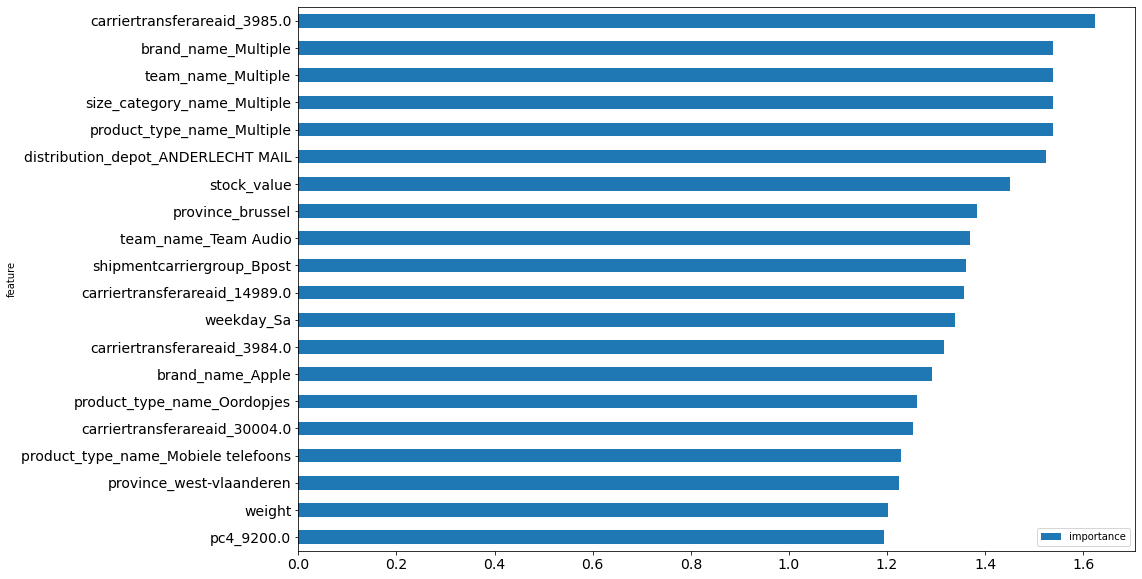

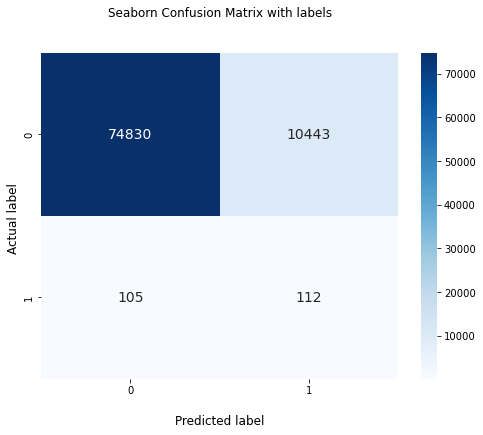